# Sentiment Analysis on a Federal Docket: Heat Injury and Illness Prevention in Outdoor and Indoor Work Settings

<b>Definitions</b><br>
- A docket is a collection of documents/text/information related to a rulemaking or regulatory action
- Regulation.gov is a centralized and public repository for these dockets. This enables transparency, and enables the public to get updated on regulatory actions
- Dockets will include a calendar of dates of the different proceedings


<b>Docket Summary:</b>

OSHA is proposing to issue a new standard, titled Heat Injury and Illness Prevention in Outdoor and Indoor Work Settings. The standard would apply to all employers conducting outdoor and indoor work in all general industry, construction, maritime, and agriculture sectors where OSHA has jurisdiction, with some exceptions. It would be a programmatic standard that would require employers to create a plan to evaluate and control heat hazards in their workplace. It would more clearly set forth employer obligations and the measures necessary to effectively protect employees from hazardous heat. OSHA requests comments on all aspects of the proposed rule.

<b>AI-guided experimental summarization and sentiment
analysis of Dockets:</b> https://www.fda.gov/media/171124/download

<b>Summary of exercise:</b>

- Select a recent, high-impact federal regulation docket from regulations.gov.
- Extract relevant data from the docket, including the proposed regulation and associated
public comments. (Note: You may select a subset of the data for analysis.)
- Perform exploratory data analysis (EDA) to explore and display key characteristics of the
textual data.
- Identify themes and extract insights from the documents.
- Apply sentiment analysis techniques to assess the public comments. Consider how
bot-generated inputs might differ from human comments.


<b>Deliverables:</b>

1. Develop a Python script that performs a comprehensive analysis of the data. You may use
either a Jupyter notebook or a standalone .py script for the implementation.
- a. Along with the source code, include a README.md file in Markdown format which
documents your solution and how to use it. Deliver the application via shared git
repository (e.g. GitHub, BitBucket).
2. Given the above, present your findings in a concise format to business stakeholders (you
can use a short summary document or a few presentation slides).
- a. Be prepared to talk about your decision-making at a high level, for tech stack,
model selection, and implementation.

# 1. Data Extraction

## Web Parsing

Using the US Gov's API key, we can the docket info from the website as well as the comments:

<b>Web Parsing Comment Data</b>

In [ ]:
from comments_downloader import CommentsDownloader
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed") 

api_key = 'BgYDvERglnMGIokigbAPUZW7KslCI1gMWa5OjEsp'
downloader = CommentsDownloader(api_key)
docket_id = 'OSHA-2021-0009-4761' 
downloader.gather_comments_by_docket(docket_id=docket_id, db_filename="testdb.db", csv_filename=r'c:\Users\U355394\Desktop\doc_comments.csv')

<b>Extracting the document information: We save the document metadata, then save the text, then export to json since excel has a size limit in each cell</b>

In [1]:
import os
from PyPDF2 import PdfReader
import requests
import json
# Replace with your actual API key
api_key = '3XTFLQVT6HgkeGm1zhfQbmf28x8x1CSBsmio1t2v'

# Base URL for the API
base_url = 'https://api.regulations.gov/v4'

# Function to get document metadata
def get_document_metadata(document_id):
    url = f'{base_url}/documents/{document_id}'
    headers = {'X-Api-Key': api_key}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f'Error: {response.status_code} - {response.text}')
        return None

# Function to download a file
def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f'File downloaded: {save_path}')
    else:
        print(f'Error: {response.status_code} - {response.text}')

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    text = ""
    try:
        pdf_reader = PdfReader(file_path)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
    except Exception as e:
        print(f"Error reading PDF file {file_path}: {e}")
    return text

# Main function to process a document
def process_document(document_id, save_folder):
    metadata = get_document_metadata(document_id)
    if metadata:
        # Ensure 'fileFormats' exists in the metadata
        if 'fileFormats' in metadata['data']['attributes']:
            file_formats = metadata['data']['attributes']['fileFormats']
            documents = []
            for file_format in file_formats:
                file_url = file_format['fileUrl']
                file_name = os.path.basename(file_url)
                save_path = os.path.join(save_folder, file_name)
                
                # Download the file
                download_file(file_url, save_path)
                
                # Extract text from the file
                text = ""
                if file_name.endswith(".pdf"):
                    text = extract_text_from_pdf(save_path)
                
                # Prepare document data
                document_data = {
                    "document_id": document_id,
                    "file_name": file_name,
                    "text": text,
                    "metadata": metadata['data']['attributes']  # Include all attributes dynamically
                }
                documents.append(document_data)
            
            # Save all documents to a JSON file
            json_filename = os.path.join(save_folder, f"{document_id}.json")
            with open(json_filename, 'w', encoding='utf-8') as json_file:
                json.dump(documents, json_file, ensure_ascii=False, indent=4)
            print(f"Data saved to '{json_filename}'")
        else:
            print('No file formats available for this document.')
    else:
        print('Failed to retrieve metadata.')

# Example Usage
save_folder = "./Document_Data"
document_ids = [
    "OSHA-2021-0009-0001",
    "OSHA-2021-0009-0178",
    "OSHA-2021-0009-1059",
    "OSHA-2021-0009-3949",
    "OSHA-2021-0009-4761"
]

for doc_id in document_ids:
    process_document(doc_id, save_folder)


File downloaded: ./Document_Data\content.pdf
File downloaded: ./Document_Data\content.htm
Data saved to './Document_Data\OSHA-2021-0009-0001.json'


KeyboardInterrupt: 

## Importing Data

<b>Importing Document Data and creating the corpus</b>

In [1]:
import pandas as pd
import os
import json
def process_json_file(file_path):
    """
    Process a single JSON file and return a pandas DataFrame with relevant data.
    """
    with open(file_path, 'r', encoding='utf-8') as json_file:
        # Load JSON data
        data = json.load(json_file)
        
        # Convert JSON data to a DataFrame
        df = pd.DataFrame(data)
        
        # Normalize metadata if it exists
        if 'metadata' in df.columns:
            metadata_df = pd.json_normalize(df['metadata'])
            
            # Concatenate metadata with the original DataFrame
            df = pd.concat([df.drop(columns=['metadata']), metadata_df], axis=1)
        
        # Rename columns as per the requirements
        column_renames = {
            "document_id": "Document_ID",
            "docAbstract": "Abstract",
            "commentStartDate": "Comment_Start_Date",
            "commentEndDate": "Comment_End_Date",
            "documentType": "Document_Type",
            "docketId": "Docket_ID",
            "postedDate": "Posted_Date",
            "text": "Text",
            'title': 'Title'
        }
        df.rename(columns=column_renames, inplace=True)
    
    return df

def process_all_json_files(folder_path):
    """
    Process all JSON files in a folder and concatenate them into a single DataFrame.
    """
    dataframes = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            # Process only JSON files
            file_path = os.path.join(folder_path, file_name)
            
            # Process each JSON file and append the resulting DataFrame
            df = process_json_file(file_path)
            dataframes.append(df)
    
    # Concatenate all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    return combined_df

# Define the folder containing the JSON files
folder_path = r'C:\Users\U355394\Desktop\Personal Projects\Document_Data'

# Process all JSON files and combine into a single DataFrame
combined_df = process_all_json_files(folder_path)

df_docs = combined_df.loc[:,['Document_ID', 'Docket_ID', 'Abstract', 'Document_Type', 'Title', 'Text', 'Comment_Start_Date', 'Comment_End_Date', 'Posted_Date']]
df_docs = df_docs.drop_duplicates(subset=['Document_ID']).reset_index(drop=True)
df_docs.head()

Document_ID       Docket_ID  \
0  OSHA-2021-0009-0001  OSHA-2021-0009   
1  OSHA-2021-0009-0178  OSHA-2021-0009   
2  OSHA-2021-0009-1059  OSHA-2021-0009   
3  OSHA-2021-0009-3949  OSHA-2021-0009   
4  OSHA-2021-0009-4761  OSHA-2021-0009   

                                            Abstract  Document_Type  \
0  Federal Register of October 27, 2021 (86 FR 59...  Proposed Rule   
1  Federal Register of December 3, 2021. (86 FR 6...  Proposed Rule   
2  The purpose of this memorandum is to notify in...          Other   
3  The purpose of this memorandum is to allow for...          Other   
4  Federal Register of August 30, 20204. (89 FR 7...  Proposed Rule   

                                               Title  \
0  Heat Injury and Illness Prevention in Outdoor ...   
1  Heat Injury and Illness Prevention in Outdoor ...   
2  Memorandum Reopening the Comment Period on Hea...   
3  Memorandum Allowing OSHA’s Supporting and Rela...   
4  Heat Injury and Illness Prevention in Outdoor ...   

                                                Text    Comment_Start_Date  \
0  59309 Federal Register / Vol. 86, No. 205 / We...  2021-10-27T04:00:00Z   
1  68594 Federal Register / Vol. 86, No. 230 / Fr...  2021-12-03T05:00:00Z   
2  August 21, 2023 \nM\nEMORANDUM  FOR:  The Gene...  2023-08-22T04:00:00Z   
3  Occupational Safety and Health Administration ...  2024-08-09T04:00:00Z   
4  70698 Federal Register / Vol. 89, No. 169 / Fr...  2024-08-30T04:00:00Z   

       Comment_End_Date           Posted_Date  
0  2022-01-27T04:59:59Z  2021-10-27T04:00:00Z  
1  2022-01-27T04:59:59Z  2021-12-03T05:00:00Z  
2  2023-12-24T04:59:59Z  2023-08-22T04:00:00Z  
3                  None  2024-08-09T04:00:00Z  
4  2024-12-31T04:59:59Z  2024-08-30T04:00:00Z

In [2]:
corpus = " ".join(df_docs['Text'].astype(str))
df_docs.loc[0, 'Corpus'] = corpus
df_docs['Corpus'] = df_docs['Corpus'].fillna('')
df_docs

Document_ID       Docket_ID  \
0  OSHA-2021-0009-0001  OSHA-2021-0009   
1  OSHA-2021-0009-0178  OSHA-2021-0009   
2  OSHA-2021-0009-1059  OSHA-2021-0009   
3  OSHA-2021-0009-3949  OSHA-2021-0009   
4  OSHA-2021-0009-4761  OSHA-2021-0009   

                                            Abstract  Document_Type  \
0  Federal Register of October 27, 2021 (86 FR 59...  Proposed Rule   
1  Federal Register of December 3, 2021. (86 FR 6...  Proposed Rule   
2  The purpose of this memorandum is to notify in...          Other   
3  The purpose of this memorandum is to allow for...          Other   
4  Federal Register of August 30, 20204. (89 FR 7...  Proposed Rule   

                                               Title  \
0  Heat Injury and Illness Prevention in Outdoor ...   
1  Heat Injury and Illness Prevention in Outdoor ...   
2  Memorandum Reopening the Comment Period on Hea...   
3  Memorandum Allowing OSHA’s Supporting and Rela...   
4  Heat Injury and Illness Prevention in Outdoor ...   

                                                Text    Comment_Start_Date  \
0  59309 Federal Register / Vol. 86, No. 205 / We...  2021-10-27T04:00:00Z   
1  68594 Federal Register / Vol. 86, No. 230 / Fr...  2021-12-03T05:00:00Z   
2  August 21, 2023 \nM\nEMORANDUM  FOR:  The Gene...  2023-08-22T04:00:00Z   
3  Occupational Safety and Health Administration ...  2024-08-09T04:00:00Z   
4  70698 Federal Register / Vol. 89, No. 169 / Fr...  2024-08-30T04:00:00Z   

       Comment_End_Date           Posted_Date  \
0  2022-01-27T04:59:59Z  2021-10-27T04:00:00Z   
1  2022-01-27T04:59:59Z  2021-12-03T05:00:00Z   
2  2023-12-24T04:59:59Z  2023-08-22T04:00:00Z   
3                  None  2024-08-09T04:00:00Z   
4  2024-12-31T04:59:59Z  2024-08-30T04:00:00Z   

                                              Corpus  
0  59309 Federal Register / Vol. 86, No. 205 / We...  
1                                                     
2                                                     
3                                                     
4

<b>Importing Comment Data:</b>

In [3]:

import pandas as pd
df_comments = pd.read_csv(r'c:\Users\U355394\Desktop\doc_comments.csv')

df_comments = df_comments.drop(columns=['Unnamed: 8'])
df_comments.head()

Comment_ID          Document_ID AgencyID                    City  \
0  OSHA-2021-0009-12956  OSHA-2021-0009-4761     OSHA            Philadelphia   
1  OSHA-2021-0009-15413  OSHA-2021-0009-4761     OSHA            Mount Vernon   
2  OSHA-2021-0009-13439  OSHA-2021-0009-4761     OSHA  Rancho Santa Margarita   
3  OSHA-2021-0009-10699  OSHA-2021-0009-4761     OSHA                New York   
4  OSHA-2021-0009-15026  OSHA-2021-0009-4761     OSHA           New Braunfels   

                                             Comment       Docket_ID  \
0  Every worker deserves protection from extreme ...  OSHA-2021-0009   
1  I fully support the Occupational Safety and He...  OSHA-2021-0009   
2  Every worker deserves protection from extreme ...  OSHA-2021-0009   
3  I am writing to support the proposed OSHA rule...  OSHA-2021-0009   
4  I fully support the Occupational Safety and He...  OSHA-2021-0009   

        DocumentType       Time of Comment  
0  Public Submission  2024-10-09T20:05:05Z  
1  Public Submission  2024-10-09T20:33:26Z  
2  Public Submission  2024-10-09T20:10:40Z  
3  Public Submission  2024-09-26T16:23:32Z  
4  Public Submission  2024-10-09T20:28:53Z

# 2. Data Pre-Processing

<b>Text Pre-Processing:</b> We remove the stop words, put comments in lower case, and Lemmatize data for Document and Comment Data

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import wordnet

def preprocess_text_column(df, text_column):
    """
    Preprocesses a text column in a DataFrame by:
    - Removing specific patterns, HTML tags, signatures, and extra whitespace.
    - Removing stopwords, punctuation, special characters, hyperlinks, and hyphens.
    - Excluding isolated single characters.
    - Selecting only valid tokens (a-z).
    - Lemmatizing tokens.
    - Joining tokens back into a single string.
    """
    processed_column = f"Processed_{text_column}"

    # Initialize stopwords and lemmatizer
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()


    def clean_text(text):
        """Cleans text by removing unwanted patterns and noise."""
        # Remove URLs
        text = re.sub(r"https?://\S+|www\.\S+", "", text)
        
        # Remove specific patterns
        text = re.sub(r"\bet al\b", "", text, flags=re.IGNORECASE)
        text = re.sub(r"\bOSHA\b", "", text, flags=re.IGNORECASE)
        text = re.sub(r"(sincerely|thank you)[\s\S]*$", "", text, flags=re.IGNORECASE)
        
        # Remove HTML tags
        text = re.sub(r"<.*?>", " ", text)
        
        # Remove isolated single characters (e.g., 'j', 'x')
        text = re.sub(r"\b[a-zA-Z]\b", "", text)
        
        # Remove HTML entities, punctuation, and non-alphanumeric characters
        text = re.sub(r"&[a-z]+;", "", text)
        text = re.sub(r"[-/\.]", " ", text)
        text = re.sub(r"[^\w\s]", "", text)
        
        # Remove specific unwanted words like "org" and "doi"
        text = re.sub(r"\b(org|doi|http|https)\b", "", text)
        
        # Remove extra whitespace
        text = re.sub(r"\s+", " ", text).strip()
        
        return text

    # Apply preprocessing
    for index, text in df[text_column].items():
        # Clean text
        cleaned_text = clean_text(text)
        
        # Tokenize and filter tokens
        tokens = word_tokenize(cleaned_text.lower())
        filtered_tokens = [
            lemmatizer.lemmatize(word, pos=wordnet.VERB)
            for word in tokens
            if word not in stop_words and re.match(r"^[a-z]+$", word)
        ]
        
        # Join tokens into a single string
        df.at[index, processed_column] = " ".join(filtered_tokens) if filtered_tokens else ""

    return df

# Apply the preprocessing function
df_comments = preprocess_text_column(df_comments, text_column="Comment")
df_docs = preprocess_text_column(df_docs, text_column="Corpus")
df_docs = preprocess_text_column(df_docs, text_column="Text")


<b>Creating tokens</b>

In [5]:
def clean(text):
    tokens = word_tokenize(text)   
    
    return tokens

df_comments["Tokens"] = df_comments["Processed_Comment"].apply(clean)
df_docs["Tokens"] = df_docs['Processed_Corpus']

<b>Adding Time Data</b>

In [6]:
df_comments['Time of Comment'] = pd.to_datetime(df_comments['Time of Comment'], format='%Y-%m-%dT%H:%M:%SZ')

df_comments['Day_of_Week'] = df_comments['Time of Comment'].dt.day_name()
df_comments['Month'] = df_comments['Time of Comment'].dt.month_name()
df_comments['Year'] = df_comments['Time of Comment'].dt.year

df_comments

Comment_ID          Document_ID AgencyID  \
0      OSHA-2021-0009-12956  OSHA-2021-0009-4761     OSHA   
1      OSHA-2021-0009-15413  OSHA-2021-0009-4761     OSHA   
2      OSHA-2021-0009-13439  OSHA-2021-0009-4761     OSHA   
3      OSHA-2021-0009-10699  OSHA-2021-0009-4761     OSHA   
4      OSHA-2021-0009-15026  OSHA-2021-0009-4761     OSHA   
...                     ...                  ...      ...   
12377   OSHA-2021-0009-3256  OSHA-2021-0009-1059      NaN   
12378   OSHA-2021-0009-2947  OSHA-2021-0009-1059      NaN   
12379   OSHA-2021-0009-1967  OSHA-2021-0009-1059      NaN   
12380   OSHA-2021-0009-3847  OSHA-2021-0009-1059      NaN   
12381   OSHA-2021-0009-3450  OSHA-2021-0009-1059      NaN   

                         City  \
0                Philadelphia   
1                Mount Vernon   
2      Rancho Santa Margarita   
3                    New York   
4               New Braunfels   
...                       ...   
12377                New York   
12378                 Chicago   
12379                Falmouth   
12380             Kansas City   
12381           New Braunfels   

                                                 Comment       Docket_ID  \
0      Every worker deserves protection from extreme ...  OSHA-2021-0009   
1      I fully support the Occupational Safety and He...  OSHA-2021-0009   
2      Every worker deserves protection from extreme ...  OSHA-2021-0009   
3      I am writing to support the proposed OSHA rule...  OSHA-2021-0009   
4      I fully support the Occupational Safety and He...  OSHA-2021-0009   
...                                                  ...             ...   
12377  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12378  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12379  James K. Hadcroft here. Please become part of ...  OSHA-2021-0009   
12380  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12381  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   

            DocumentType     Time of Comment  \
0      Public Submission 2024-10-09 20:05:05   
1      Public Submission 2024-10-09 20:33:26   
2      Public Submission 2024-10-09 20:10:40   
3      Public Submission 2024-09-26 16:23:32   
4      Public Submission 2024-10-09 20:28:53   
...                  ...                 ...   
12377                NaN 2024-01-09 05:00:00   
12378                NaN 2024-01-08 05:00:00   
12379                NaN 2023-12-22 05:00:00   
12380                NaN 2024-01-12 05:00:00   
12381                NaN 2024-01-10 05:00:00   

                                       Processed_Comment  \
0      every worker deserve protection extreme heat w...   
1      fully support occupational safety health admin...   
2      every worker deserve protection extreme heat w...   
3      write support propose rule protect non residen...   
4      fully support occupational safety health admin...   
...                                                  ...   
12377  urge swiftly issue strong preventative heat st...   
12378  urge swiftly issue strong preventative heat st...   
12379  jam hadcroft please become part solution urge ...   
12380  urge swiftly issue strong preventative heat st...   
12381  urge swiftly issue strong preventative heat st...   

                                                  Tokens Day_of_Week  \
0      [every, worker, deserve, protection, extreme, ...   Wednesday   
1      [fully, support, occupational, safety, health,...   Wednesday   
2      [every, worker, deserve, protection, extreme, ...   Wednesday   
3      [write, support, propose, rule, protect, non, ...    Thursday   
4      [fully, support, occupational, safety, health,...   Wednesday   
...                                                  ...         ...   
12377  [urge, swiftly, issue, strong, preventative, h...     Tuesday   
12378  [urge, swiftly, issue, strong, preventative, h...      Monday   
12379  [jam, hadcroft, pleas

# 3. Exploratory Data Analysis

<b>Example of Comments which become duplicates after pre-processing data:</b>

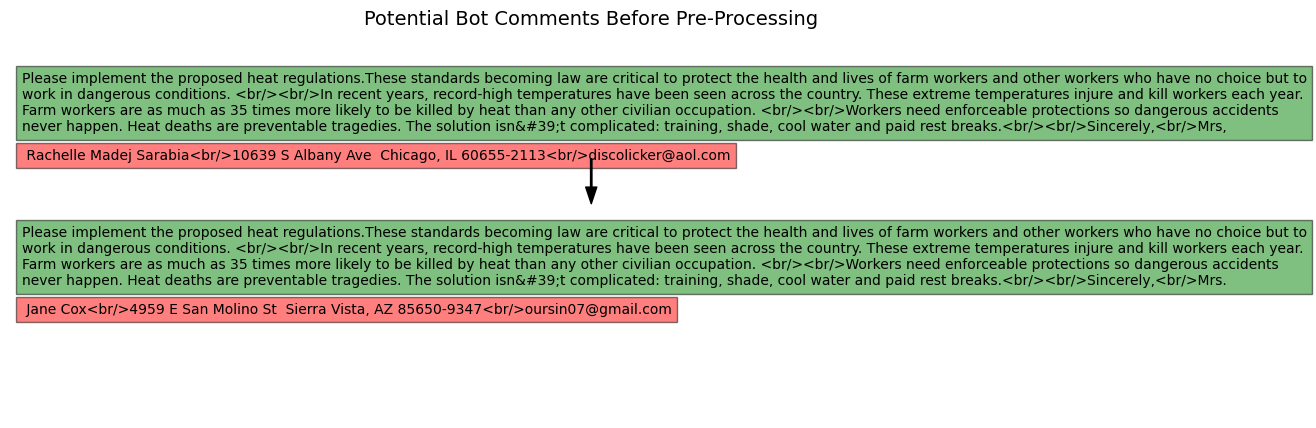

In [7]:
import matplotlib.pyplot as plt

# Raw comment
comment_1 = df_comments['Comment'].iloc[20] # Change the index to pick a different comment
comment_2 = df_comments['Comment'].iloc[21] # Change the index to pick a different comment

# Split into two parts: highlighted and the rest
highlighted_text_1 = comment_1.split("Mrs.")[0] + "Mrs,"
remaining_text_1 = comment_1[len(highlighted_text_1):]

# Split into two parts: highlighted and the rest
highlighted_text_2 = comment_2.split("Mrs.")[0] + "Mrs."
remaining_text_2 = comment_2[len(highlighted_text_2):]

# Plot
plt.figure(figsize=(15, 5))

# Add the highlighted text
plt.text(0.01, 0.9, highlighted_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="green", alpha=0.5), wrap=True)

# Add the remaining text
plt.text(0.01, 0.70, remaining_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="red", alpha=0.5),wrap=True)
# Add an arrow pointing downward
plt.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.68), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

# Add the second comment with highlighted text
plt.text(0.01, 0.5, highlighted_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="green", alpha=0.5), wrap=True)
plt.text(0.01, 0.30, remaining_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="red", alpha=0.5), wrap=True)
# Set up the plot
plt.axis('off') # Turn off axes for clean visualization
plt.title("Potential Bot Comments Before Pre-Processing", fontsize=14)
plt.show()


<b>Comments becoming duplicates after pre-preprocessing:</b>

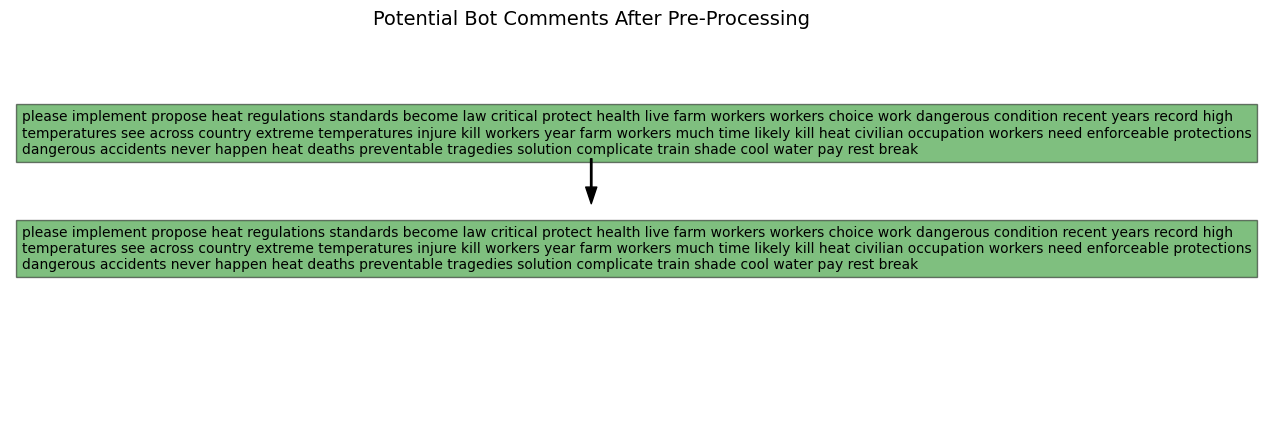

In [8]:
# Raw comment
comment_1 = df_comments['Processed_Comment'].iloc[20]
comment_2 = df_comments['Processed_Comment'].iloc[21] 

# Plot
plt.figure(figsize=(15, 5))

# Add the highlighted text
plt.text(0.01, 0.8, comment_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="green", alpha=0.5), wrap=True)

# Add an arrow pointing downward
plt.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.68), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

# Add the second comment with highlighted text
plt.text(0.01, 0.5, comment_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="green", alpha=0.5), wrap=True)
# Set up the plot
plt.axis('off') # Turn off axes for clean visualization
plt.title("Potential Bot Comments After Pre-Processing", fontsize=14)
plt.show()

<b>Number of Duplicates after Pre-Processing:</b>

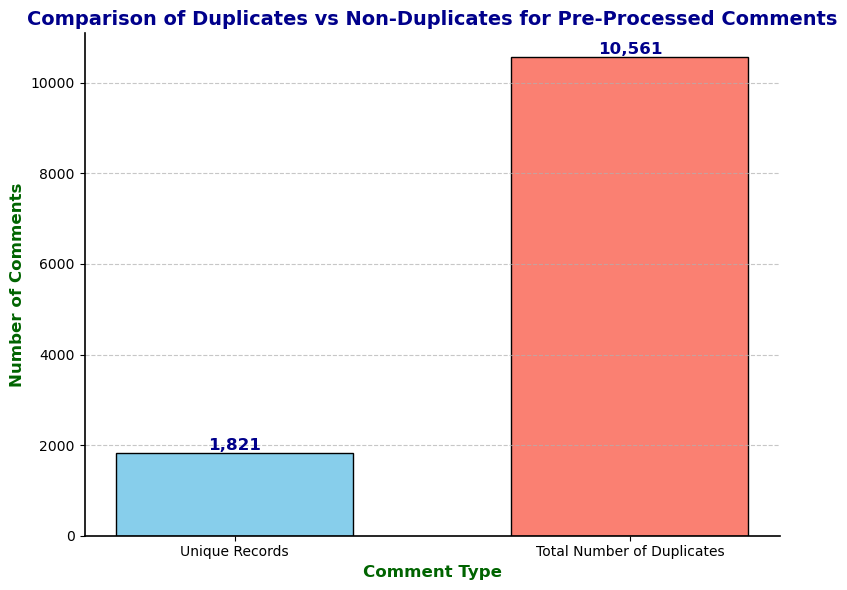

In [9]:

# Calculate duplicates and non-duplicates
duplicates_count = df_comments["Processed_Comment"].duplicated(keep=False).sum()
non_duplicates_count = len(df_comments) - duplicates_count

# Data for the plot
labels = ['Unique Records', 'Total Number of Duplicates']
counts = [non_duplicates_count, duplicates_count]

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color=['skyblue', 'salmon'], edgecolor='black', width=0.6)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f"{height:,}",  # Format the numbers with commas
        ha='center', va='bottom', fontsize=12, weight='bold', color='darkblue'
    )

# Style the plot
ax.set_title("Comparison of Duplicates vs Non-Duplicates for Pre-Processed Comments", fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel("Number of Comments", fontsize=12, fontweight='bold', color='darkgreen')
ax.set_xlabel("Comment Type", fontsize=12, fontweight='bold', color='darkgreen')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<b>Comment Similarity:</b> Let's look at the cosine similarity and find comments with the highest cosine similarity

In [10]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Step 1: Prepare the text data
# Tokenize the comments into lists of words

# Step 2: Train or load a pre-trained Word2Vec model
# Train a Word2Vec model on the tokenized comments
word2vec_model = Word2Vec(sentences=df_comments['Tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Compute sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentence, model):
    words = [word for word in sentence if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

df_comments['Embedding'] = df_comments['Tokens'].apply(lambda x: get_sentence_embedding(x, word2vec_model))

# Step 4: Compute cosine similarity between sentence embeddings
embeddings = np.array(df_comments['Embedding'].tolist())
cosine_sim = cosine_similarity(embeddings, embeddings)

# Step 5: Find the most similar comment and similarity score for each comment
highest_similarity_scores = []
most_similar_comments = []

for i in range(len(cosine_sim)):
    # Exclude self-similarity (diagonal elements)
    cosine_sim[i, i] = 0
    max_sim_idx = cosine_sim[i].argmax()  # Index of the highest similarity score
    highest_similarity_scores.append(cosine_sim[i].max())  # Highest similarity score
    most_similar_comments.append(df_comments['Comment'].iloc[max_sim_idx])  # Corresponding comment

# Step 6: Add the results to the DataFrame
df_comments['Highest_Similarity_Score'] = highest_similarity_scores
df_comments['Most_Similar_Comment'] = most_similar_comments

# Display the final DataFrame
df_comments[['Comment', 'Highest_Similarity_Score', 'Most_Similar_Comment']].head()

Comment  \
0  Every worker deserves protection from extreme ...   
1  I fully support the Occupational Safety and He...   
2  Every worker deserves protection from extreme ...   
3  I am writing to support the proposed OSHA rule...   
4  I fully support the Occupational Safety and He...   

   Highest_Similarity_Score                               Most_Similar_Comment  
0                       1.0  Every worker deserves protection from extreme ...  
1                       1.0  I fully support the Occupational Safety and He...  
2                       1.0  Every worker deserves protection from extreme ...  
3                       1.0  I am writing to support the proposed OSHA rule...  
4                       1.0  I fully support the Occupational Safety and He...

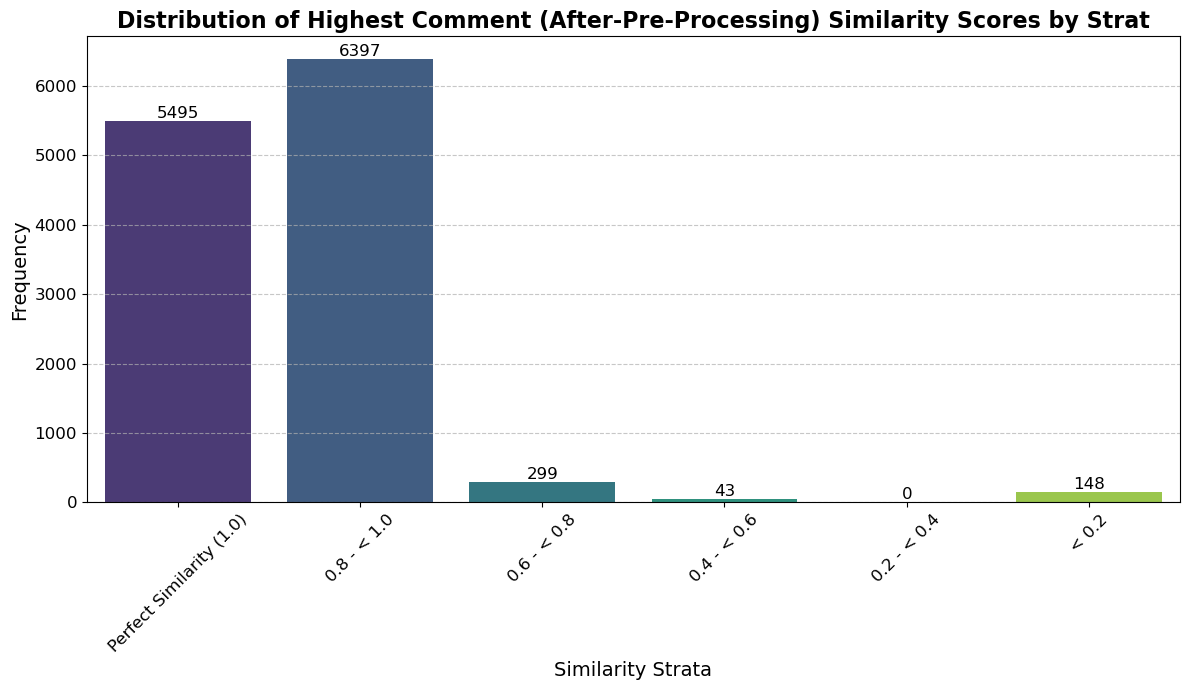

In [11]:
import seaborn as sns
# Step 1: Bin the similarity scores into strata
def stratify_score(score):
    if score == 1.0:
        return "Perfect Similarity (1.0)"
    elif score >= 0.8:
        return "0.8 - < 1.0"
    elif score >= 0.6:
        return "0.6 - < 0.8"
    elif score >= 0.4:
        return "0.4 - < 0.6"
    elif score >= 0.2:
        return "0.2 - < 0.4"
    else:
        return "< 0.2"

df_comments['Similarity_Strat'] = df_comments['Highest_Similarity_Score'].apply(stratify_score)

# Step 2: Count the frequency of each strat and ensure all strata are included
strata_order = ["Perfect Similarity (1.0)", "0.8 - < 1.0", "0.6 - < 0.8", "0.4 - < 0.6", "0.2 - < 0.4", "< 0.2"]
strat_counts = df_comments['Similarity_Strat'].value_counts().reindex(strata_order, fill_value=0).reset_index()
strat_counts.columns = ['Similarity_Strat', 'Count']

# Step 3: Plot the data
plt.figure(figsize=(12, 7))
sns.barplot(data=strat_counts, x='Similarity_Strat', y='Count', palette='viridis')
plt.title('Distribution of Highest Comment (After-Pre-Processing) Similarity Scores by Strat', fontsize=16, fontweight='bold')
plt.xlabel('Similarity Strata', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.bar_label(plt.gca().containers[0], fmt='%d', fontsize=12, label_type='edge')  # Add labels to bars
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<b>Analyzing Time Stamps Between Comments: </b> We find suspicious patterns with regards to bot activity

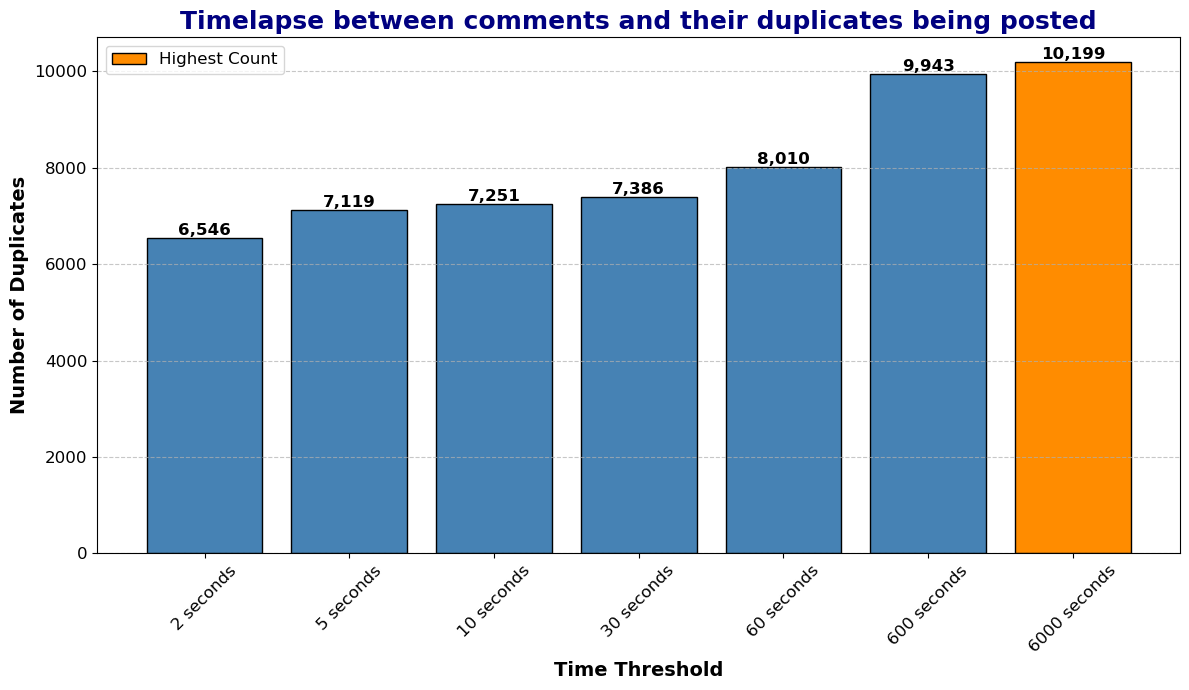

In [13]:
from datetime import timedelta


# Step 1: Identify Duplicates
df_comments['Is_Duplicate'] = df_comments.duplicated(subset=['Processed_Comment'], keep=False)

# Step 2: Calculate Time Difference
# Sort by 'Processed_Comment' and 'Time of Comment' for accurate time difference calculation
df_comments_time_lapse = df_comments.sort_values(by=['Processed_Comment', 'Time of Comment']).reset_index(drop=True)

# Create a column for the time difference between consecutive duplicates
df_comments_time_lapse['Time_Difference'] = df_comments_time_lapse.groupby('Processed_Comment')['Time of Comment'].diff()

# Step 3: Count duplicates within time thresholds
thresholds = [2, 5, 10, 30, 60, 600, 6000]  # Seconds
threshold_counts = {}

for threshold in thresholds:
    threshold_timedelta = timedelta(seconds=threshold)
    threshold_counts[f"{threshold} seconds"] = df_comments_time_lapse[
        (df_comments_time_lapse['Is_Duplicate']) & (df_comments_time_lapse['Time_Difference'] <= threshold_timedelta)
    ].shape[0]

# Convert the threshold counts into a DataFrame for plotting
threshold_df = pd.DataFrame({
    "Threshold": threshold_counts.keys(),
    "Duplicate_Counts": threshold_counts.values()
})

# Step 4: Enhanced Visualization
plt.figure(figsize=(12, 7))
bars = plt.bar(threshold_df['Threshold'], threshold_df['Duplicate_Counts'], color='steelblue', edgecolor='black')

# Add labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, f"{yval:,}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add aesthetic touches
plt.title("Timelapse between comments and their duplicates being posted", fontsize=18, fontweight='bold', color='navy')
plt.xlabel("Time Threshold", fontsize=14, fontweight='bold')
plt.ylabel("Number of Duplicates", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the bar with the maximum value for emphasis
max_value = max(threshold_df['Duplicate_Counts'])
max_bar = bars[threshold_df['Duplicate_Counts'].idxmax()]
max_bar.set_color('darkorange')
max_bar.set_edgecolor('black')

# Add a legend
plt.legend([max_bar], ["Highest Count"], loc='upper left', fontsize=12)

# Final layout adjustments
plt.tight_layout()
plt.show()

In [14]:
# Step 2: Calculate Time Difference
# Sort by 'Processed_Comment' and 'Time of Comment' for accurate time difference calculation
df_comments.Is_Duplicate_After_PreProcess.value_counts()

Is_Duplicate_After_PreProcess
True     10561
False     1821
Name: count, dtype: int64

In [15]:
df_comments_dif = df_comments
df_comments_dif[df_comments_dif['Is_Duplicate_After_PreProcess'] == True]

Comment_ID          Document_ID AgencyID  \
0      OSHA-2021-0009-12956  OSHA-2021-0009-4761     OSHA   
1      OSHA-2021-0009-15413  OSHA-2021-0009-4761     OSHA   
2      OSHA-2021-0009-13439  OSHA-2021-0009-4761     OSHA   
3      OSHA-2021-0009-10699  OSHA-2021-0009-4761     OSHA   
4      OSHA-2021-0009-15026  OSHA-2021-0009-4761     OSHA   
...                     ...                  ...      ...   
12376   OSHA-2021-0009-2424  OSHA-2021-0009-1059      NaN   
12377   OSHA-2021-0009-3256  OSHA-2021-0009-1059      NaN   
12378   OSHA-2021-0009-2947  OSHA-2021-0009-1059      NaN   
12380   OSHA-2021-0009-3847  OSHA-2021-0009-1059      NaN   
12381   OSHA-2021-0009-3450  OSHA-2021-0009-1059      NaN   

                         City  \
0                Philadelphia   
1                Mount Vernon   
2      Rancho Santa Margarita   
3                    New York   
4               New Braunfels   
...                       ...   
12376                   Anoka   
12377                New York   
12378                 Chicago   
12380             Kansas City   
12381           New Braunfels   

                                                 Comment       Docket_ID  \
0      Every worker deserves protection from extreme ...  OSHA-2021-0009   
1      I fully support the Occupational Safety and He...  OSHA-2021-0009   
2      Every worker deserves protection from extreme ...  OSHA-2021-0009   
3      I am writing to support the proposed OSHA rule...  OSHA-2021-0009   
4      I fully support the Occupational Safety and He...  OSHA-2021-0009   
...                                                  ...             ...   
12376  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12377  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12378  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12380  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   
12381  I urge you to swiftly issue a strong, preventa...  OSHA-2021-0009   

            DocumentType     Time of Comment  \
0      Public Submission 2024-10-09 20:05:05   
1      Public Submission 2024-10-09 20:33:26   
2      Public Submission 2024-10-09 20:10:40   
3      Public Submission 2024-09-26 16:23:32   
4      Public Submission 2024-10-09 20:28:53   
...                  ...                 ...   
12376                NaN 2024-01-04 05:00:00   
12377                NaN 2024-01-09 05:00:00   
12378                NaN 2024-01-08 05:00:00   
12380                NaN 2024-01-12 05:00:00   
12381                NaN 2024-01-10 05:00:00   

                                       Processed_Comment  \
0      every worker deserve protection extreme heat w...   
1      fully support occupational safety health admin...   
2      every worker deserve protection extreme heat w...   
3      write support propose rule protect non residen...   
4      fully support occupational safety health admin...   
...                                                  ...   
12376  urge swiftly issue strong preventative heat st...   
12377  urge swiftly issue strong preventative heat st...   
12378  urge swiftly issue strong preventative heat st...   
12380  urge swiftly issue strong preventative heat st...   
12381  urge swiftly issue strong preventative heat st...   

                                                  Tokens Day_of_Week  \
0      [every, worker, deserve, protection, extreme, ...   Wednesday   
1      [fully, support, occupational, safety, health,...   Wednesday   
2      [every, worker, deserve, protection, extreme, ...   Wednesday   
3      [write, support, propose, rule, protect, non, ...    Thursday   
4      [fully, support, occupational, safety, health,...   Wednesday   
...                                                  ...         ...   
12376  [urge, swiftly, issue, strong, preventative, h...    Thursday   
12377  [urge, swiftly, issue, strong, preventative, h...     Tuesday   
12378  [urge, swiftly, issue

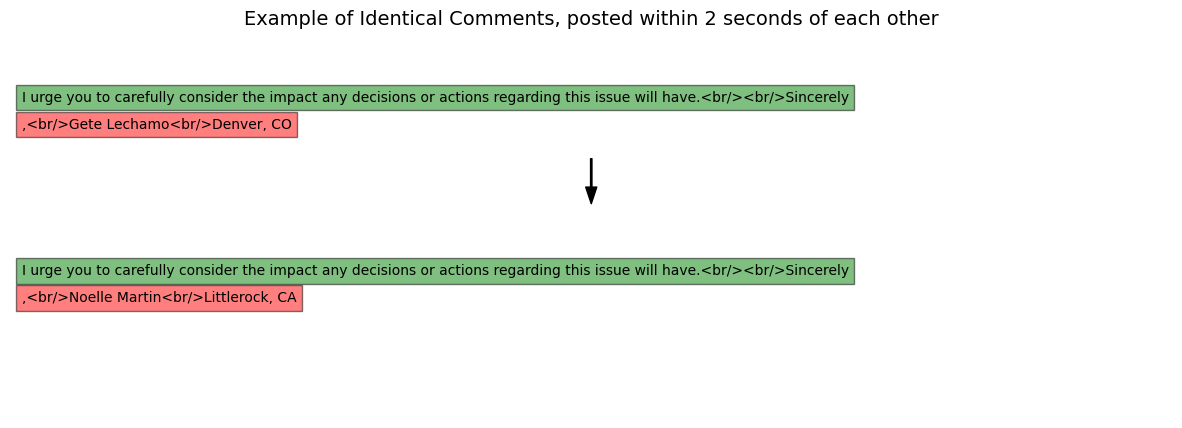

In [16]:
# Create a column for the time difference between consecutive duplicates
df_comments_dif['Time_Difference'] = df_comments_dif.groupby('Processed_Comment')['Time of Comment'].diff()

# Step 3: Extract Rows with Duplicates under 2 Seconds
threshold_timedelta = timedelta(seconds=2)
duplicates_under_two_seconds = df_comments_dif[
    (df_comments_dif['Is_Duplicate']) & (df_comments_dif['Time_Difference'] <= threshold_timedelta)
]
duplicates_under_two_seconds_comment = duplicates_under_two_seconds['Comment'].iloc[2]
duplicates_under_two_seconds_comment_dup = duplicates_under_two_seconds.Most_Similar_Comment.iloc[2]

# Raw comment
comment_1 = duplicates_under_two_seconds_comment # Change the index to pick a different comment
comment_2 = duplicates_under_two_seconds_comment_dup # Change the index to pick a different comment

# Split into two parts: highlighted and the rest
highlighted_text_1 = comment_1.split("Sincerely")[0] + "Sincerely"
remaining_text_1 = comment_1[len(highlighted_text_1):]

# Split into two parts: highlighted and the rest
highlighted_text_2 = comment_2.split("Sincerely")[0] + "Sincerely"
remaining_text_2 = comment_2[len(highlighted_text_2):]

# Plot
plt.figure(figsize=(15, 5))

# Add the highlighted text
plt.text(0.01, 0.85, highlighted_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="green", alpha=0.5), wrap=True)

# Add the remaining text
plt.text(0.01, 0.78, remaining_text_1, fontsize=10, color="black", ha='left', va='top',bbox=dict(facecolor="red", alpha=0.5),wrap=True)
# Add an arrow pointing downward
plt.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.68), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

# Add the second comment with highlighted text
plt.text(0.01, 0.4, highlighted_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="green", alpha=0.5), wrap=True)
plt.text(0.01, 0.33, remaining_text_2, fontsize=10, color="black", ha='left', va='top', 
         bbox=dict(facecolor="red", alpha=0.5), wrap=True)
# Set up the plot
plt.axis('off') # Turn off axes for clean visualization
plt.title("Example of Identical Comments, posted within 2 seconds of each other", fontsize=14)
plt.show()


<b>Classification of Bot Comments:</b>
If a comment has at least 95% similarity score with 10 or more other comments
    and has a comment with a 95% similarity score sent within 6000 seconds, then we create a bot column called Is_Bot, and put "Yes" under it

In [17]:

# Assuming 'cosine_sim' and 'df_comments' from the Word2Vec implementation are available

# Convert the 'Time of Comment' column to datetime if it's not already
df_comments['Time of Comment'] = pd.to_datetime(df_comments['Time of Comment'])

# Step 1: Identify comments with at least 95% similarity to 5 or more other comments
similarity_threshold = 0.95
time_threshold = pd.Timedelta(seconds=6000)  # 6000 seconds as a timedelta

# Initialize a list to track bot classification
is_bot = []

for i in range(len(df_comments)):
    # Find indices of comments with similarity >= 95%
    similar_indices = np.where(cosine_sim[i] >= similarity_threshold)[0]
    # Count the number of such comments
    similar_count = len(similar_indices)
    
    # Check the timestamps of similar comments
    if similar_count >= 5:
        timestamps = df_comments['Time of Comment'].iloc[similar_indices]
        time_differences = abs(timestamps - df_comments['Time of Comment'].iloc[i])
        if any(time_differences <= time_threshold):
            is_bot.append("Yes")
        else:
            is_bot.append("No")
    else:
        is_bot.append("No")

# Step 2: Add the 'Is_Bot' column to the DataFrame
df_comments['Is_Bot'] = is_bot

<b>We find that a lot of the comments are bots:</b>

In [18]:
df_comments['Is_Bot'].value_counts()

Is_Bot
Yes    11486
No       896
Name: count, dtype: int64

<b>Save Bot Comments in a df:</b>

In [19]:
df_bot = df_comments[df_comments['Is_Bot'] == 'Yes'].reset_index(drop=True)
df_bot.head()

Comment_ID          Document_ID AgencyID                    City  \
0  OSHA-2021-0009-12956  OSHA-2021-0009-4761     OSHA            Philadelphia   
1  OSHA-2021-0009-15413  OSHA-2021-0009-4761     OSHA            Mount Vernon   
2  OSHA-2021-0009-13439  OSHA-2021-0009-4761     OSHA  Rancho Santa Margarita   
3  OSHA-2021-0009-10699  OSHA-2021-0009-4761     OSHA                New York   
4  OSHA-2021-0009-15026  OSHA-2021-0009-4761     OSHA           New Braunfels   

                                             Comment       Docket_ID  \
0  Every worker deserves protection from extreme ...  OSHA-2021-0009   
1  I fully support the Occupational Safety and He...  OSHA-2021-0009   
2  Every worker deserves protection from extreme ...  OSHA-2021-0009   
3  I am writing to support the proposed OSHA rule...  OSHA-2021-0009   
4  I fully support the Occupational Safety and He...  OSHA-2021-0009   

        DocumentType     Time of Comment  \
0  Public Submission 2024-10-09 20:05:05   
1  Public Submission 2024-10-09 20:33:26   
2  Public Submission 2024-10-09 20:10:40   
3  Public Submission 2024-09-26 16:23:32   
4  Public Submission 2024-10-09 20:28:53   

                                   Processed_Comment  \
0  every worker deserve protection extreme heat w...   
1  fully support occupational safety health admin...   
2  every worker deserve protection extreme heat w...   
3  write support propose rule protect non residen...   
4  fully support occupational safety health admin...   

                                              Tokens  ...      Month  Year  \
0  [every, worker, deserve, protection, extreme, ...  ...    October  2024   
1  [fully, support, occupational, safety, health,...  ...    October  2024   
2  [every, worker, deserve, protection, extreme, ...  ...    October  2024   
3  [write, support, propose, rule, protect, non, ...  ...  September  2024   
4  [fully, support, occupational, safety, health,...  ...    October  2024   

                                           Embedding Highest_Similarity_Score  \
0  [-0.55552137, -0.8392707, -0.19922227, 0.04535...                      1.0   
1  [-0.2686548, 0.66192806, -0.38999742, -0.01745...                      1.0   
2  [-0.55552137, -0.8392707, -0.19922227, 0.04535...                      1.0   
3  [-0.18622698, -0.33368847, -0.9478784, 0.05646...                      1.0   
4  [-0.2686548, 0.66192806, -0.38999742, -0.01745...                      1.0   

                                Most_Similar_Comment  \
0  Every worker deserves protection from extreme ...   
1  I fully support the Occupational Safety and He...   
2  Every worker deserves protection from extreme ...   
3  I am writing to support the proposed OSHA rule...   
4  I fully support the Occupational Safety and He...   

           Similarity_Strat Is_Duplicate_After_PreProcess  Is_Duplicate  \
0  Perfect Similarity (1.0)                          True          True   
1  Perfect Similarity (1.0)                          True          True   
2  Perfect Similarity (1.0)                          True          True   
3               0.8 - < 1.0                          True          True   
4  Perfect Similarity (1.0)                          True          True   

    Time_Difference Is_Bot  
0               NaT    Yes  
1               NaT    Yes  
2   0 days 00:05:35    Yes  
3               NaT    Yes  
4 -1 days +23:55:27    Yes  

[5 rows x 21 columns]

<b>We Remove Bots and Duplicate Comments After Pre-Processing</b>

In [22]:
import numpy as np
df_comments.replace(r'^\s*$', np.nan, regex=True)
df_comments = df_comments[(df_comments['Is_Bot'] == 'No') & (df_comments['Is_Duplicate'] == False)].reset_index(drop=True)
df_comments.head()

Comment_ID          Document_ID AgencyID           City  \
0  OSHA-2021-0009-12073  OSHA-2021-0009-4761     OSHA            NaN   
1   OSHA-2021-0009-7700  OSHA-2021-0009-4761     OSHA  San Francisco   
2  OSHA-2021-0009-12082  OSHA-2021-0009-4761     OSHA            NaN   
3   OSHA-2021-0009-6366  OSHA-2021-0009-4761     OSHA            NaN   
4  OSHA-2021-0009-11769  OSHA-2021-0009-4761     OSHA            NaN   

                                             Comment       Docket_ID  \
0  As an HVAC installer, I regularly work in atti...  OSHA-2021-0009   
1  Please implement the proposed heat regulations...  OSHA-2021-0009   
2  I&#39;d think this is good however what are th...  OSHA-2021-0009   
3  I support this rule to protect workers against...  OSHA-2021-0009   
4  Heat injury and illness prevention become ever...  OSHA-2021-0009   

        DocumentType     Time of Comment  \
0  Public Submission 2024-10-07 16:31:25   
1  Public Submission 2024-09-19 12:59:15   
2  Public Submission 2024-10-07 16:38:04   
3  Public Submission 2024-09-16 13:32:58   
4  Public Submission 2024-10-01 13:40:59   

                                   Processed_Comment  \
0  hvac installer regularly work attics heat summ...   
1  please implement propose heat regulations abso...   
2                    think good however implications   
3  support rule protect workers heat injury illne...   
4  heat injury illness prevention become ever cru...   

                                              Tokens  ...      Month  Year  \
0  [hvac, installer, regularly, work, attics, hea...  ...    October  2024   
1  [please, implement, propose, heat, regulations...  ...  September  2024   
2               [think, good, however, implications]  ...    October  2024   
3  [support, rule, protect, workers, heat, injury...  ...  September  2024   
4  [heat, injury, illness, prevention, become, ev...  ...    October  2024   

                                           Embedding Highest_Similarity_Score  \
0  [-0.37381116, 0.1930182, 0.09112906, -0.072286...                 0.727547   
1  [-0.257278, 0.016682256, -0.23415682, 0.131314...                 0.859483   
2  [0.002604954, 0.0023808866, 0.16019695, 0.2008...                 0.939921   
3  [-0.02227657, 0.31026772, 0.0023577877, -0.015...                 0.854592   
4  [0.4159708, 0.4451694, -0.31690812, 0.01706051...                 0.706026   

                                Most_Similar_Comment Similarity_Strat  \
0  Even tho California has rules against this, I&...      0.6 - < 0.8   
1  Please implement the proposed heat regulations...      0.8 - < 1.0   
2                                              Good.      0.8 - < 1.0   
3         if you have heat illness just drink water.      0.8 - < 1.0   
4  As a farmer, I know how crucial shade, water b...      0.6 - < 0.8   

  Is_Duplicate_After_PreProcess  Is_Duplicate  Time_Difference Is_Bot  
0                         False         False              NaT     No  
1                         False         False              NaT     No  
2                         False         False              NaT     No  
3                         False         False              NaT     No  
4                         False         False              NaT     No  

[5 rows x 21 columns]

<b>Word Cloud and Term Frequency for comments:</b>

In [24]:
pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/00/09/abb305dce85911b8fba382926cfc57f2f257729e25937fdcc63f3a1a67f9/wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata
  Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl (299 kB)
Note: you may need to restart the kernel to use updated packages.


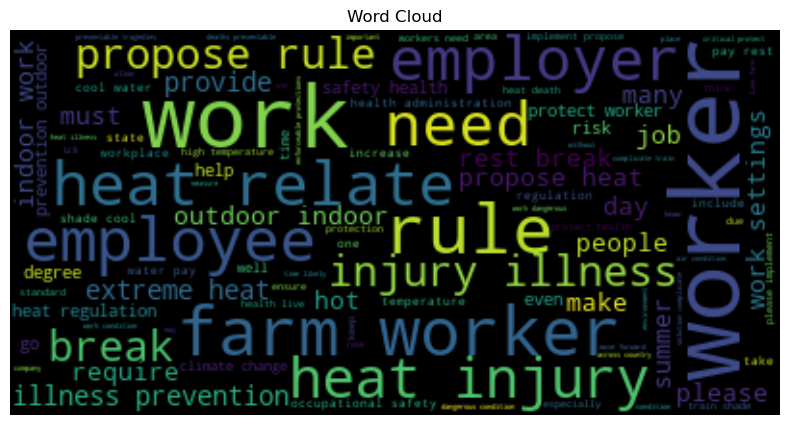

In [25]:
from wordcloud import WordCloud
from collections import Counter

def plot_tf_and_wordcloud(df, column_name, max_font_size=50, max_words=100, background_color="black"):
    # 1. Term Frequency Calculation and Bar Chart

    text = " ".join(i for i in df[column_name])
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud")
    plt.axis("off")
    plt.show()
plot_tf_and_wordcloud(df_comments, "Processed_Comment")
    

top_words = Counter([item for sublist in df_comments['Tokens'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')
    # 2. Word Cloud Generation
top_words_df.style.background_gradient(cmap='Blues')


<b>For Documents</b>

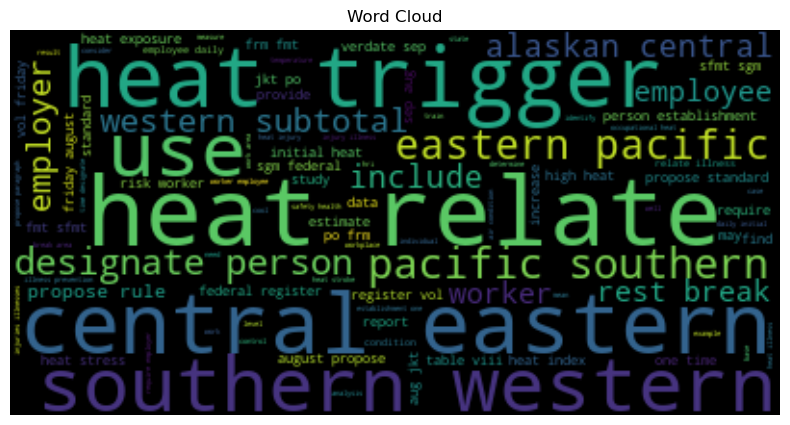

In [26]:
plot_tf_and_wordcloud(df_docs, "Processed_Corpus")
df_docs['temp_list'] = df_docs['Processed_Corpus'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df_docs['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count'])


    # 2. Word Cloud Generation
top_words_df.style.background_gradient(cmap='Blues')

<b>Graph Showing the proportion per POS Tag:</b> This suggests that the majority is of the processed comments mostly contain nouns, following by a high count of adjectives, then plurial nouns

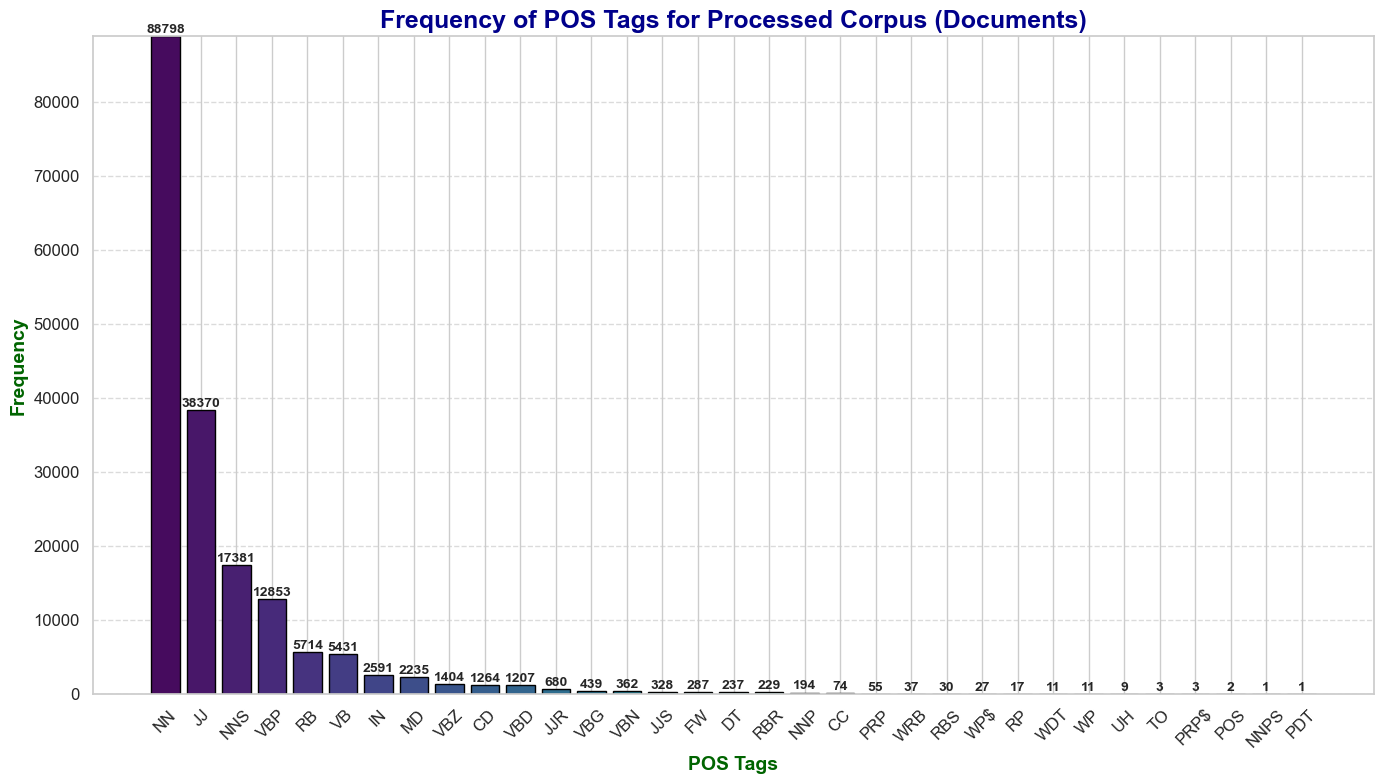

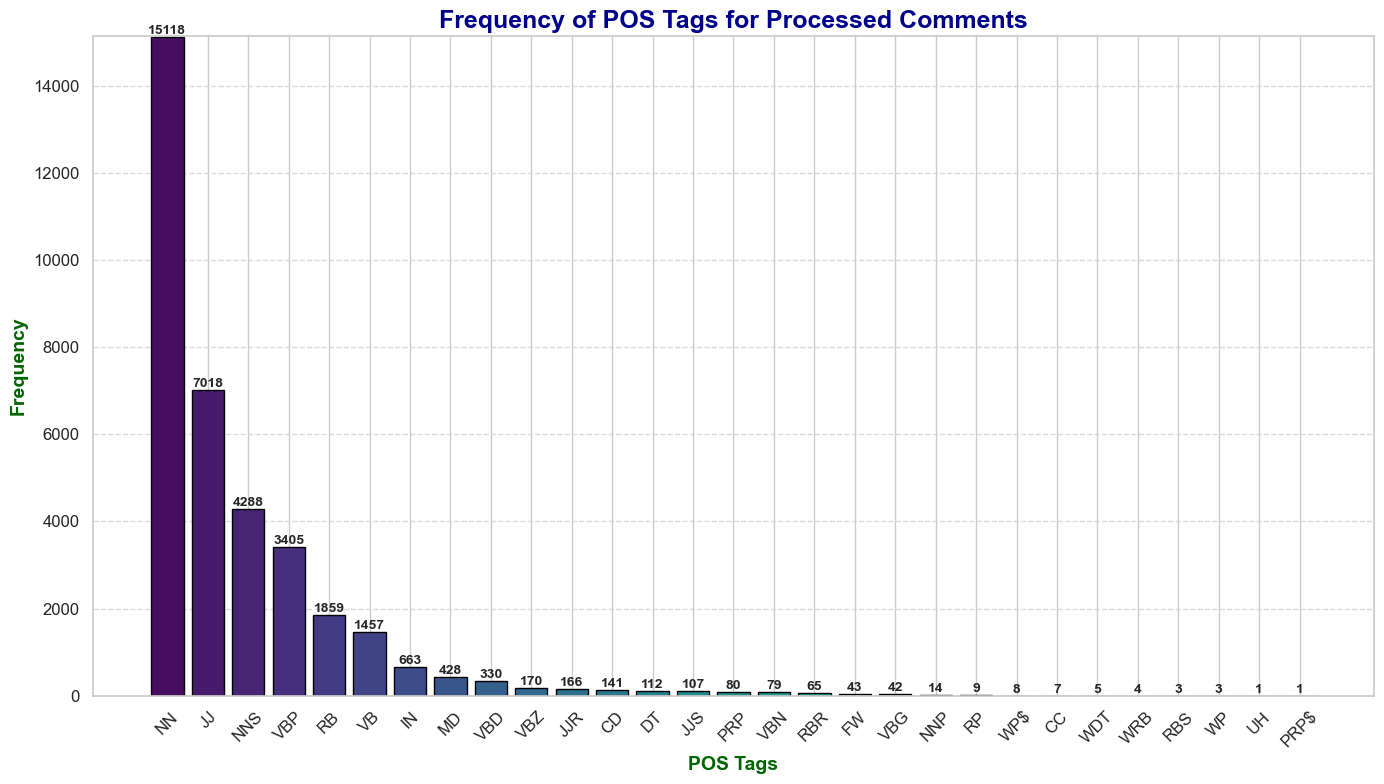

In [27]:
import nltk
import seaborn as sns
# Assuming df is already processed and contains the 'Processed_Comments' column

# Function to perform POS tagging and generate a plot
def plot_pos_tags(df, column, title):
    # Tokenize the specified column
    df['tokens'] = df[column].apply(word_tokenize)
    
    # Flatten the list of tokenized sentences
    all_words = [word for sublist in df['tokens'] for word in sublist]
    
    # Perform POS tagging
    pos_tags = nltk.pos_tag(all_words)
    
    # Count the frequency of each POS tag
    pos_counts = Counter(tag for word, tag in pos_tags)
    
    # Sort the tags and counts by frequency in descending order
    sorted_pos_counts = sorted(pos_counts.items(), key=lambda item: item[1], reverse=True)
    
    # Separate tags and their counts for plotting
    tags, counts = zip(*sorted_pos_counts)
    
    # Set the style and color palette
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", len(tags))
    
    # Create the bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(tags, counts, color=palette, edgecolor='black')
    
    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize the appearance
    plt.title(title, fontsize=18, fontweight='bold', color='darkblue')
    plt.xlabel("POS Tags", fontsize=14, fontweight='bold', color='darkgreen')
    plt.ylabel("Frequency", fontsize=14, fontweight='bold', color='darkgreen')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, max(counts) + 10)
    
    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Apply the function to df_docs and df_comments
plot_pos_tags(df_docs, 'Processed_Corpus', "Frequency of POS Tags for Processed Corpus (Documents)")
plot_pos_tags(df_comments, 'Processed_Comment', "Frequency of POS Tags for Processed Comments")


<b>Length of Processed Comments:</b> the violin graph has a long tail distribution, showing that shorter comments are more common with a concentration of 50 to 100 words.

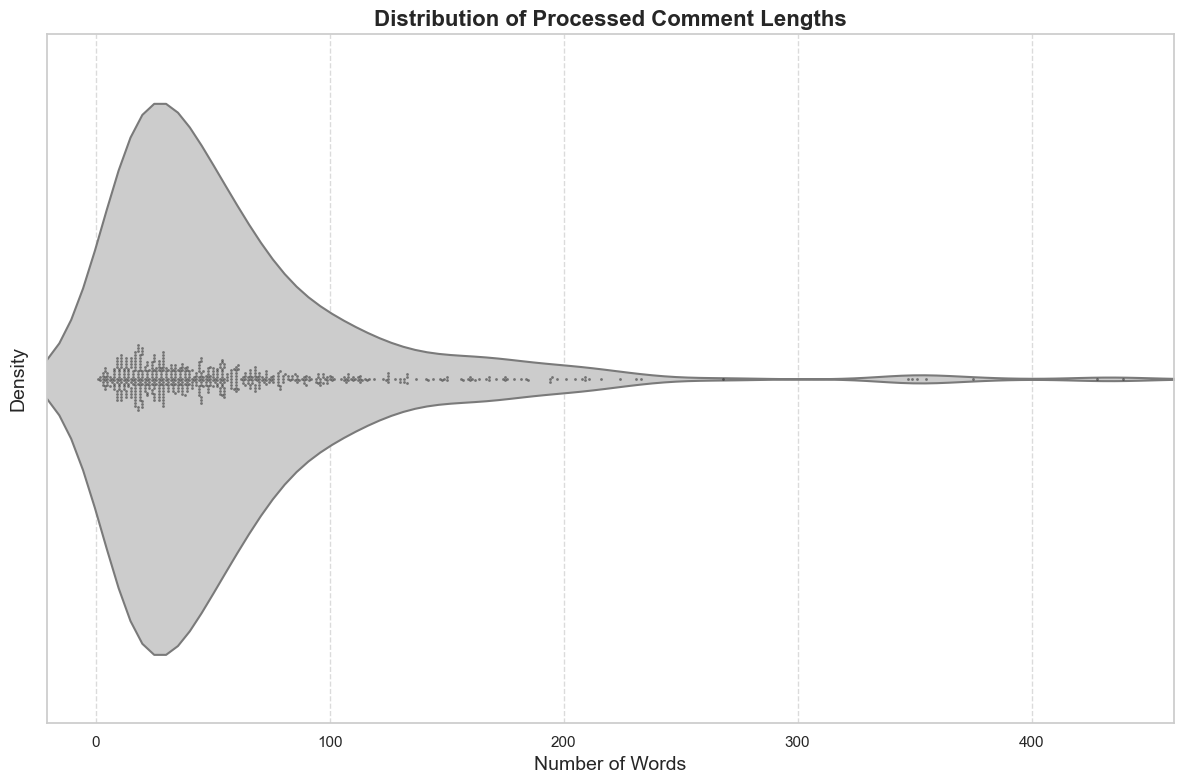

In [28]:
# Define a function to calculate lengths and plot the distribution
def plot_comment_length_distribution(df, column, title):
    """
    Function to calculate comment lengths and create a violin plot with swarm overlay.
    
    Args:
        df (DataFrame): DataFrame containing the data.
        column (str): The column containing processed text.
        title (str): Title of the plot.
    
    Returns:
        None
    """
    # Calculate the length of each comment
    df['Comment_Length'] = df[column].apply(lambda x: len(word_tokenize(str(x))))
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Create a violin plot
    sns.violinplot(x=df['Comment_Length'], inner=None, color=".8")
    
    # Overlay a swarm plot
    sns.swarmplot(x=df['Comment_Length'], size=2, color='k', alpha=0.5)
    
    # Customize the plot
    plt.title(f'Distribution of {title} Lengths', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Words', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Apply the function to both DataFrames
plot_comment_length_distribution(df_comments, 'Processed_Comment', "Processed Comment")

<b>N-Grams:</b> 'workers', 'heat', and 'work' are the most common unigrams, indicating the prevalence of discussions surrounding workers conditions in the docket comments. Bi-grams show the prevalence of safety measures and policy considerations. Same with Tri-grams, showing the geographical implications regarding the docket.

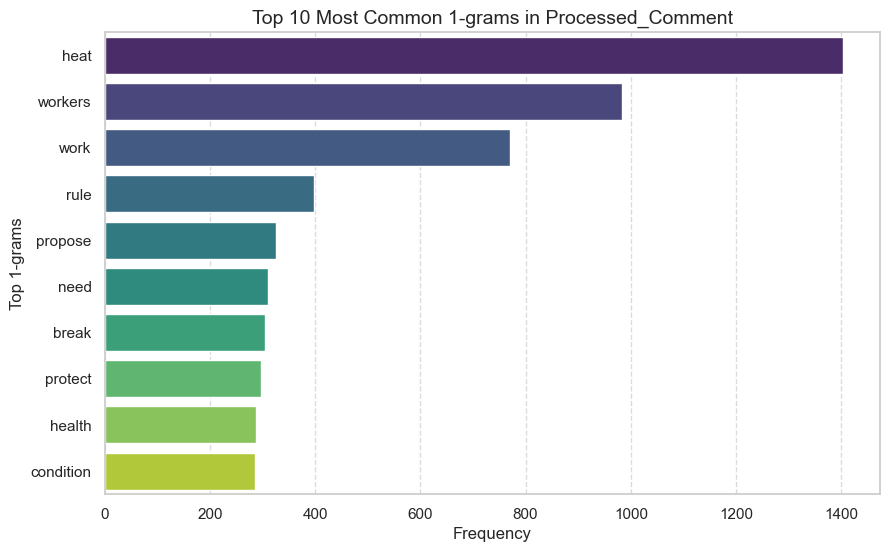

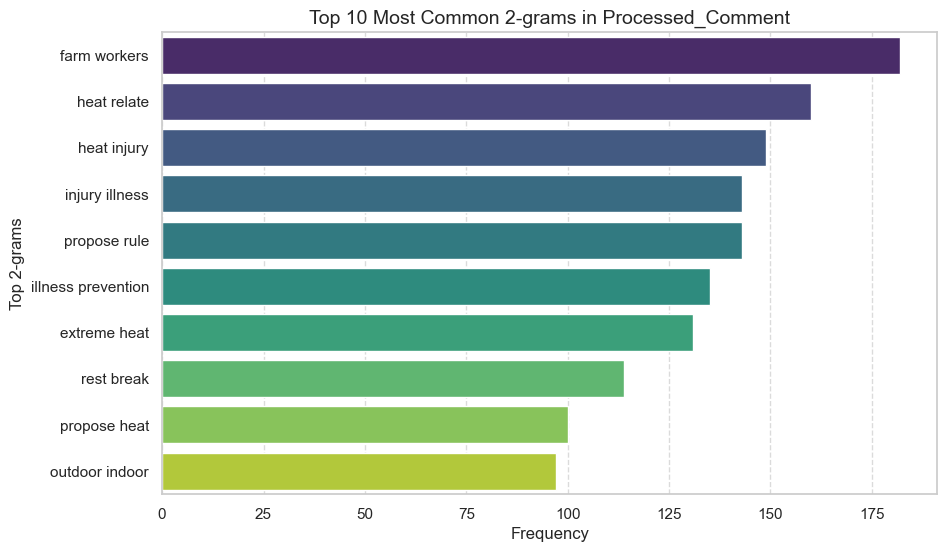

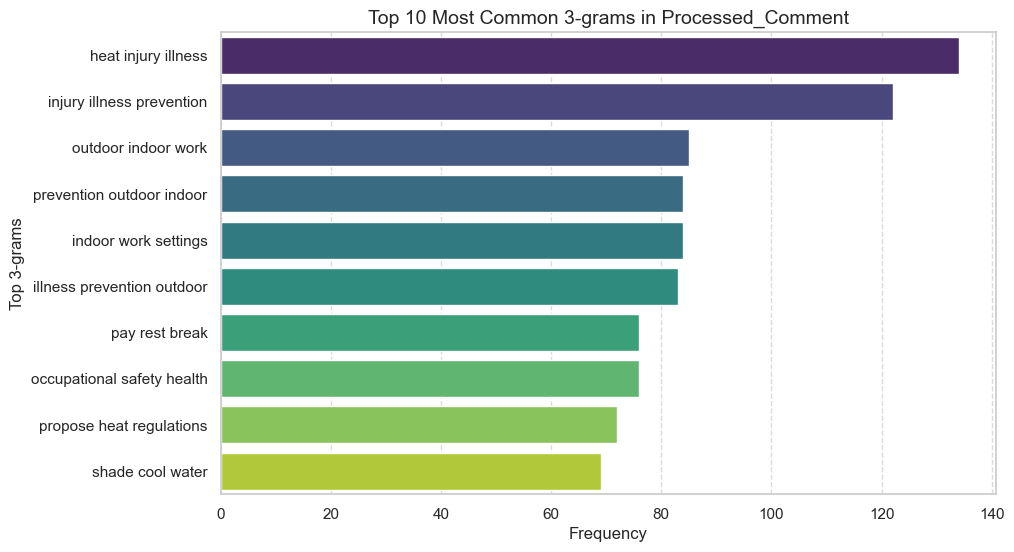

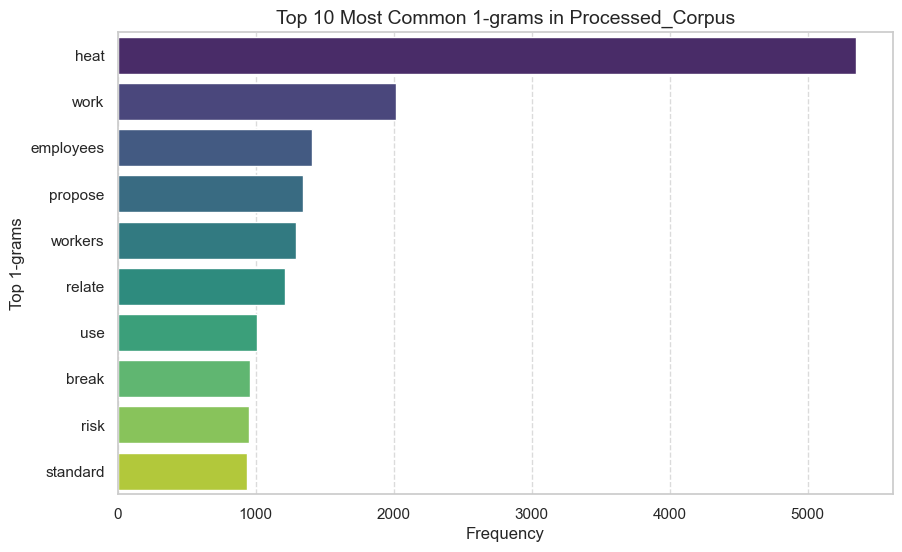

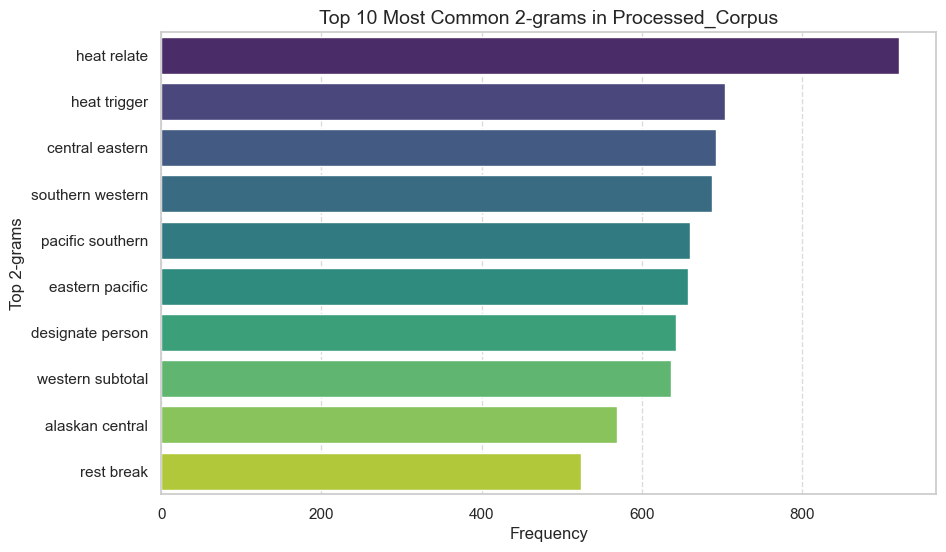

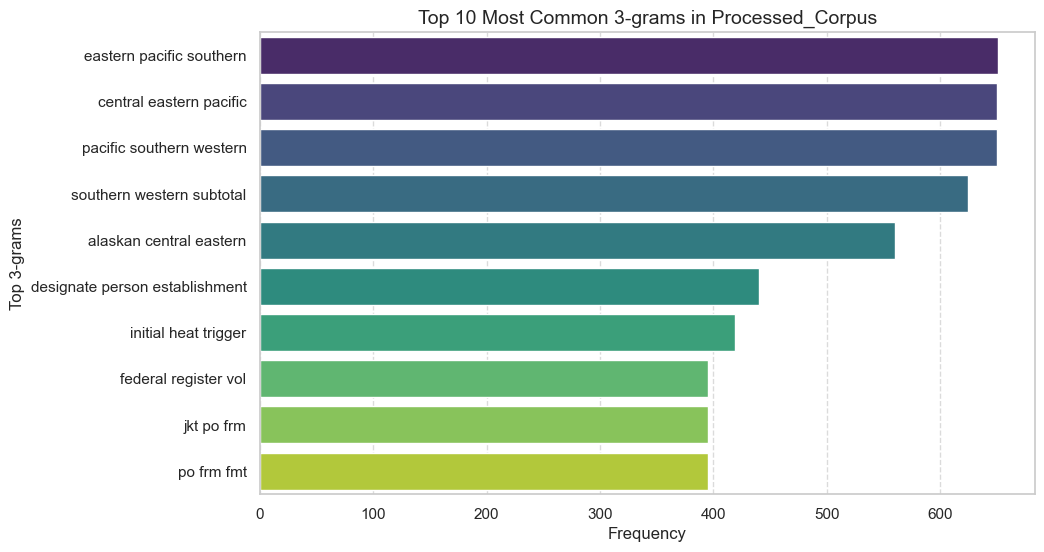

In [29]:
from nltk.util import ngrams
# Function to generate n-grams
def generate_ngrams(text, n):
    tokens = word_tokenize(text.lower())
    n_grams = ngrams(tokens, n)
    return [' '.join(grams) for grams in n_grams]

# Function to plot n-gram frequencies
def plot_ngrams(df, text_column, n, top_n=10, dataset_label=''):
    # Generate n-grams
    df[f'{n}-grams'] = df[text_column].apply(lambda x: generate_ngrams(x, n))
    
    # Flatten the list of n-grams
    all_ngrams = [ngram for sublist in df[f'{n}-grams'] for ngram in sublist]
    
    # Count the frequency of each n-gram
    ngram_freq = Counter(all_ngrams)
    
    # Get the most common n-grams
    common_ngrams = ngram_freq.most_common(top_n)
    
    # Separate the n-grams and their frequencies for plotting
    ngrams_list, frequencies = zip(*common_ngrams)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(frequencies), y=list(ngrams_list), palette='viridis')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel(f'Top {n}-grams', fontsize=12)
    plt.title(f'Top {top_n} Most Common {n}-grams in {dataset_label}', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Plot unigrams, bigrams, and trigrams for comments
plot_ngrams(df_comments, 'Processed_Comment', 1, top_n=10, dataset_label='Processed_Comment')
plot_ngrams(df_comments, 'Processed_Comment', 2, top_n=10, dataset_label='Processed_Comment')
plot_ngrams(df_comments, 'Processed_Comment', 3, top_n=10, dataset_label='Processed_Comment')

# Plot unigrams, bigrams, and trigrams for documents
plot_ngrams(df_docs, 'Processed_Corpus', 1, top_n=10, dataset_label='Processed_Corpus')
plot_ngrams(df_docs, 'Processed_Corpus', 2, top_n=10, dataset_label='Processed_Corpus')
plot_ngrams(df_docs, 'Processed_Corpus', 3, top_n=10, dataset_label='Processed_Corpus')

# 4. Sentiment Analysis

<b>Additional Filtering</b>

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df_comments_sentiment = df_comments.copy()

<b>Create 5 variations of Pre-Processing</b>

In [ ]:
pip 

In [33]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell, Verbosity
import re
import pkg_resources
from string import punctuation

# Initialize tools
stop_words = set(stopwords.words("english"))
punctuation_list = set(punctuation).union({"@", "http", "https", "org", "doi"})
stemmer = PorterStemmer()


# Initialize SymSpell object
max_edit_distance = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance, prefix_length)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Function to clean text
def clean_text(text):
    """Cleans text for general text analysis."""
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"\b[a-zA-Z]\b", "", text)  # Remove single characters
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

# Function to tokenize and filter text
def tokenize_and_filter(text):
    """Tokenizes and removes stopwords, punctuation, and non-alphabetic tokens."""
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word not in stop_words and word not in punctuation_list and re.match(r"^[a-z]+$", word)]

# Function to apply spell check
def spell_check(text):
    if isinstance(text, str) and text.strip():
        words = text.split()
        corrected_words = []
        for word in words:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
            if suggestions:
                corrected_words.append(suggestions[0].term)
            else:
                corrected_words.append(word)
        return " ".join(corrected_words)
    return text

# Apply preprocessing to the DataFrame
df_comments_sentiment['Processed_Comments'] = df_comments_sentiment['Comment'].apply(clean_text)
df_comments_sentiment['Lemmatized_Comments'] = df_comments_sentiment['Processed_Comments'].apply(
    lambda x: " ".join(word_tokenize(x))
)
df_comments_sentiment['Stemmed_Comments'] = df_comments_sentiment['Processed_Comments'].apply(
    lambda x: " ".join(stemmer.stem(word) for word in tokenize_and_filter(x))
)
df_comments_sentiment['Basic_Cleaned'] = df_comments_sentiment['Comment'].apply(clean_text)

# Create a new column: Spell-Checked and Stemmed
df_comments_sentiment['Stemmed_With_Spellcheck'] = df_comments_sentiment['Processed_Comments'].apply(spell_check).apply(
    lambda x: " ".join(stemmer.stem(word) for word in tokenize_and_filter(x))
)

# Display the resulting DataFrame
df_comments_sentiment[['Comment', 'Processed_Comments', 'Lemmatized_Comments', 'Stemmed_Comments', 'Stemmed_With_Spellcheck']].head()


Comment  \
0  As an HVAC installer, I regularly work in atti...   
1  Please implement the proposed heat regulations...   
2  I&#39;d think this is good however what are th...   
3  I support this rule to protect workers against...   
4  Heat injury and illness prevention become ever...   

                                  Processed_Comments  \
0  As an HVAC installer regularly work in attics ...   
1  Please implement the proposed heat regulations...   
2  39 think this is good however what are the imp...   
3  support this rule to protect workers against h...   
4  Heat injury and illness prevention become ever...   

                                 Lemmatized_Comments  \
0  As an HVAC installer regularly work in attics ...   
1  Please implement the proposed heat regulations...   
2  39 think this is good however what are the imp...   
3  support this rule to protect workers against h...   
4  Heat injury and illness prevention become ever...   

                                    Stemmed_Comments  \
0  hvac instal regularli work attic heat summer a...   
1  pleas implement propos heat regul absolut dyst...   
2                  think good howev implicationsbrbr   
3  support rule protect worker heat injuri ill sp...   
4  heat injuri ill prevent becom ever crucial hot...   

                             Stemmed_With_Spellcheck  
0  hvac instal regularli work attic heat summer a...  
1  pleas implement propos heat regul absolut dyst...  
2                  think good howev implicationsbrbr  
3  support rule protect worker heat injuri ill sp...  
4  heat injuri ill prevent becom ever crucial hot...

<b>Vader Sentiment and TextBlob Sentiment Analyzers all 5 columns with Sentiment Classification Threshold:</b>

In [35]:
pip install textblob

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
  Using cached textblob-0.18.0.post0-py3-none-any.whl.metadata (4.5 kB)
Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)
Note: you may need to restart the kernel to use updated packages.


In [36]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

def analyze_sentiment(df, text_columns, analyzer):
    """
    Applies the specified sentiment analyzer (VADER or TextBlob) to multiple text columns in a DataFrame.
    Creates sentiment score and classification columns for each text column.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the text columns.
    text_columns (list): A list of column names to analyze sentiment for.
    analyzer (str): The type of sentiment analyzer to use ('vader' or 'textblob').
    
    Returns:
    pd.DataFrame: The original DataFrame with added sentiment scores and classifications for the specified analyzer.
    """
    # Initialize the VADER analyzer if selected
    if analyzer.lower() == 'vader':
        sentiment_analyzer = SentimentIntensityAnalyzer()
    
    # Function to classify sentiment based on score
    def classify_sentiment(score):
        if score > 0.6:
            return 'Very Positive'
        elif score > 0.2:
            return 'Positive'
        elif score >= -0.2:
            return 'Neutral'
        elif score >= -0.6:
            return 'Negative'
        else:
            return 'Very Negative'
    
    # Apply sentiment analysis to each specified column
    for column in text_columns:
        if analyzer.lower() == 'vader':
            score_column = f"{column}_Score_Vader"
            sentiment_column = f"{column}_Sentiment_Vader"
            
            # Compute sentiment scores using VADER
            df[score_column] = df[column].apply(
                lambda text: sentiment_analyzer.polarity_scores(text)['compound'] if isinstance(text, str) else 0.0
            )
            
            # Classify sentiment based on scores
            df[sentiment_column] = df[score_column].apply(classify_sentiment)
        
        elif analyzer.lower() == 'textblob':
            score_column = f"{column}_Score_TextBlob"
            sentiment_column = f"{column}_Sentiment_TextBlob"
            
            # Compute sentiment polarity scores using TextBlob
            df[score_column] = df[column].apply(
                lambda text: TextBlob(text).sentiment.polarity if isinstance(text, str) else 0.0
            )
            
            # Classify sentiment based on scores
            df[sentiment_column] = df[score_column].apply(classify_sentiment)
        
        else:
            raise ValueError("Invalid analyzer type. Please choose 'vader' or 'textblob'.")
    
    return df




In [37]:
# Columns to analyze
text_columns = [
    "Processed_Comment",
    "Lemmatized_Comments",
    "Stemmed_Comments",
    "Basic_Cleaned",
    "Stemmed_With_Spellcheck"
]

# Perform sentiment analysis with VADER
df_vader_sentiment = analyze_sentiment(df_comments_sentiment, text_columns, analyzer="vader")
print("VADER Sentiment Analysis Results:")
print(df_vader_sentiment.head())

# Perform sentiment analysis with TextBlob
df_textblob_sentiment = analyze_sentiment(df_comments_sentiment, text_columns, analyzer="textblob")
print("\nTextBlob Sentiment Analysis Results:")
print(df_textblob_sentiment.head())


VADER Sentiment Analysis Results:
             Comment_ID          Document_ID AgencyID           City  \
0  OSHA-2021-0009-12073  OSHA-2021-0009-4761     OSHA            NaN   
1   OSHA-2021-0009-7700  OSHA-2021-0009-4761     OSHA  San Francisco   
2  OSHA-2021-0009-12082  OSHA-2021-0009-4761     OSHA            NaN   
3   OSHA-2021-0009-6366  OSHA-2021-0009-4761     OSHA            NaN   
4  OSHA-2021-0009-11769  OSHA-2021-0009-4761     OSHA            NaN   

                                             Comment       Docket_ID  \
0  As an HVAC installer, I regularly work in atti...  OSHA-2021-0009   
1  Please implement the proposed heat regulations...  OSHA-2021-0009   
2  I&#39;d think this is good however what are th...  OSHA-2021-0009   
3  I support this rule to protect workers against...  OSHA-2021-0009   
4  Heat injury and illness prevention become ever...  OSHA-2021-0009   

        DocumentType     Time of Comment  \
0  Public Submission 2024-10-07 16:31:25   
1  Public Su

<b>Function For Sentiment Pie Chart:</b>

In [38]:
def plot_sentiment_pie_charts(df, columns_to_visualize):
    """
    Plots sentiment pie charts for the specified columns in a 2-2-1 layout.

    Parameters:
    df (DataFrame): The DataFrame containing sentiment data.
    columns_to_visualize (list): List of column names to visualize.

    Returns:
    None: Displays the pie charts.
    """
    # Define colors for each sentiment category
    colors = {
        'Very Negative': '#8B0000',  # Dark Red
        'Negative': '#FF6347',       # Light Red
        'Neutral': '#FFD700',        # Yellow
        'Positive': '#90EE90',       # Light Green
        'Very Positive': '#006400'   # Dark Green
    }

    # Define the desired order of sentiments
    sentiment_order = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

    # Create subplots with a custom grid layout (3 rows, adjust spans to achieve 2-2-1)
    fig = plt.figure(figsize=(16, 10))  # Adjust figsize as needed
    grid_spec = fig.add_gridspec(3, 2)  # 3 rows, 2 columns

    # Axes list for assigning subplots to a custom layout
    axes = [
        fig.add_subplot(grid_spec[0, 0]),  # Row 1, Column 1
        fig.add_subplot(grid_spec[0, 1]),  # Row 1, Column 2
        fig.add_subplot(grid_spec[1, 0]),  # Row 2, Column 1
        fig.add_subplot(grid_spec[1, 1]),  # Row 2, Column 2
        fig.add_subplot(grid_spec[2, :])   # Row 3, Spanning both columns
    ]

    # Loop through each column and corresponding subplot axis
    for ax, column in zip(axes, columns_to_visualize):
        # Count occurrences of each sentiment
        sentiment_counts = df[column].value_counts()

        # Reorder sentiment_counts according to the desired order
        sentiment_counts = sentiment_counts.reindex(sentiment_order, fill_value=0)

        # Create a list of colors in the order of sentiment_counts index
        color_list = [colors[sentiment] for sentiment in sentiment_counts.index]

        # Create the pie chart
        wedges, texts, autotexts = ax.pie(
            x=sentiment_counts,
            labels=sentiment_counts.index,
            autopct='%1.1f%%',
            wedgeprops=dict(width=0.7),
            textprops=dict(size=10, color="black"),
            pctdistance=0.85,
            colors=color_list,
            shadow=True
        )

        # Enhance label positioning
        for text, autotext in zip(texts, autotexts):
            autotext.set_color('black')
            autotext.set_weight('bold')
            autotext.set_size(8)
            text.set_size(9)

        # Add a white center circle
        center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
        ax.add_artist(center_circle)

        # Add a title to each subplot (showing only the part before '_Sentiment')
        title = column.split('_Sentiment')[0]
        ax.set_title(f"{title} Distribution", fontsize=12, fontweight='bold', color='#333333')
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a DataFrame 'df' and columns to visualize
# plot_sentiment_pie_charts(df, ['Column1_Sentiment', 'Column2_Sentiment'])


<b>Vader Sentiment Pie Charts</b>

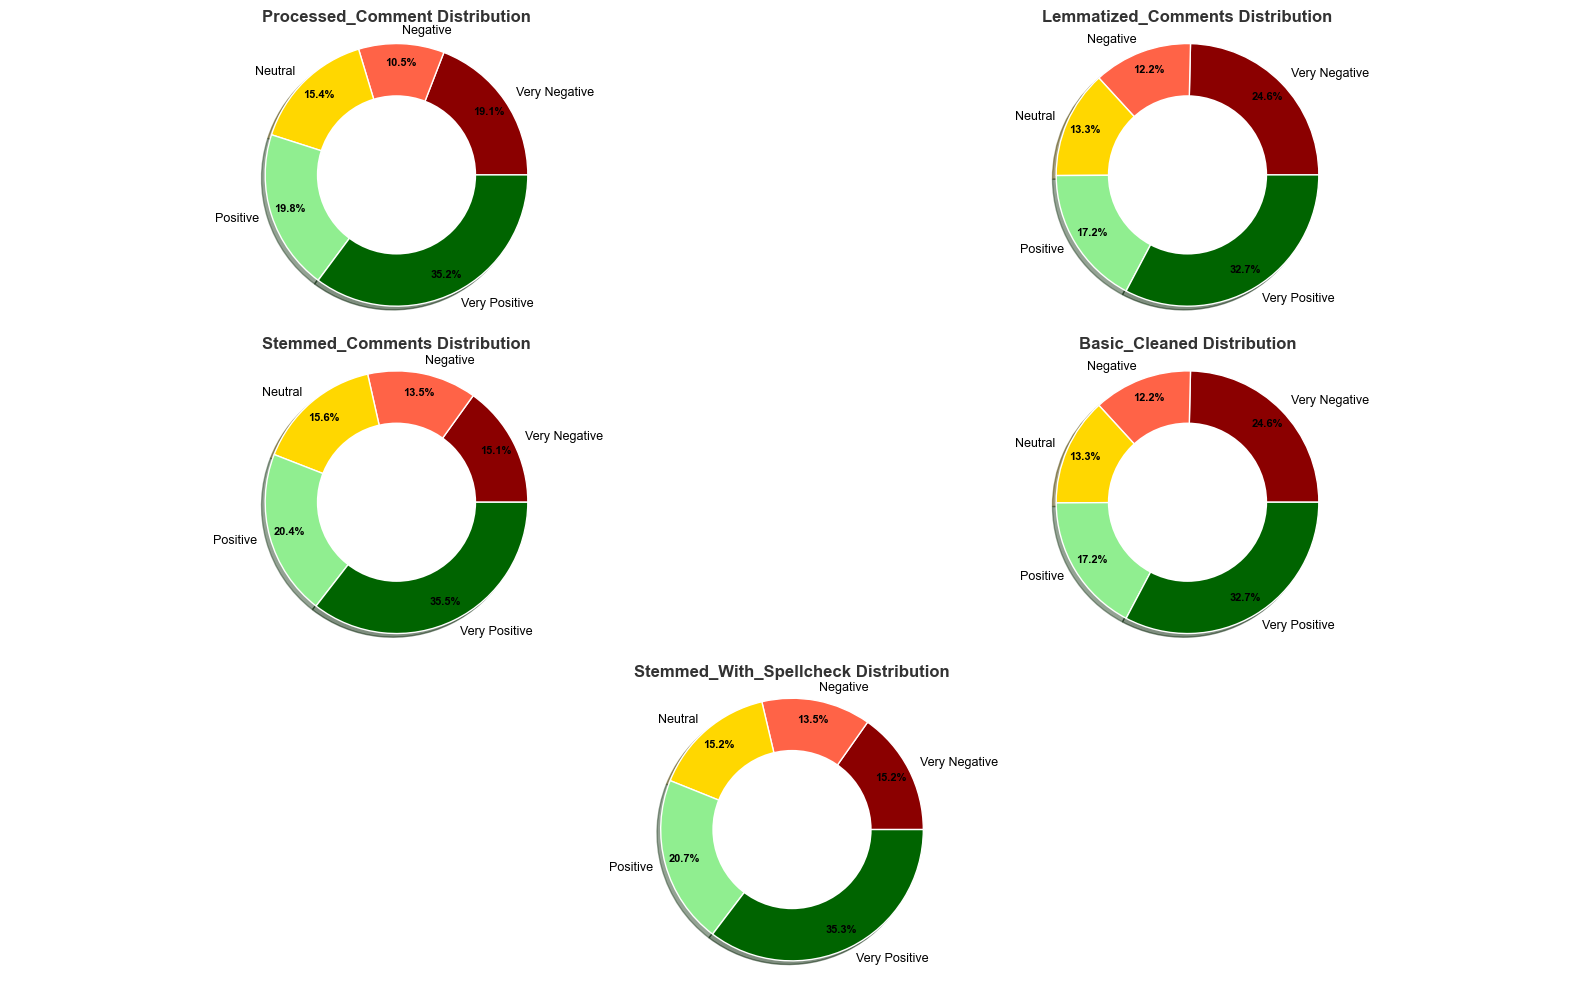

In [39]:
columns = [
    "Processed_Comment_Sentiment_Vader",
    "Lemmatized_Comments_Sentiment_Vader",
    "Stemmed_Comments_Sentiment_Vader",
    "Basic_Cleaned_Sentiment_Vader",
    'Stemmed_With_Spellcheck_Sentiment_Vader'
]

# Call the function
plot_sentiment_pie_charts(df_vader_sentiment, columns)

<b>TexBlob Sentiment Pie Charts</b>

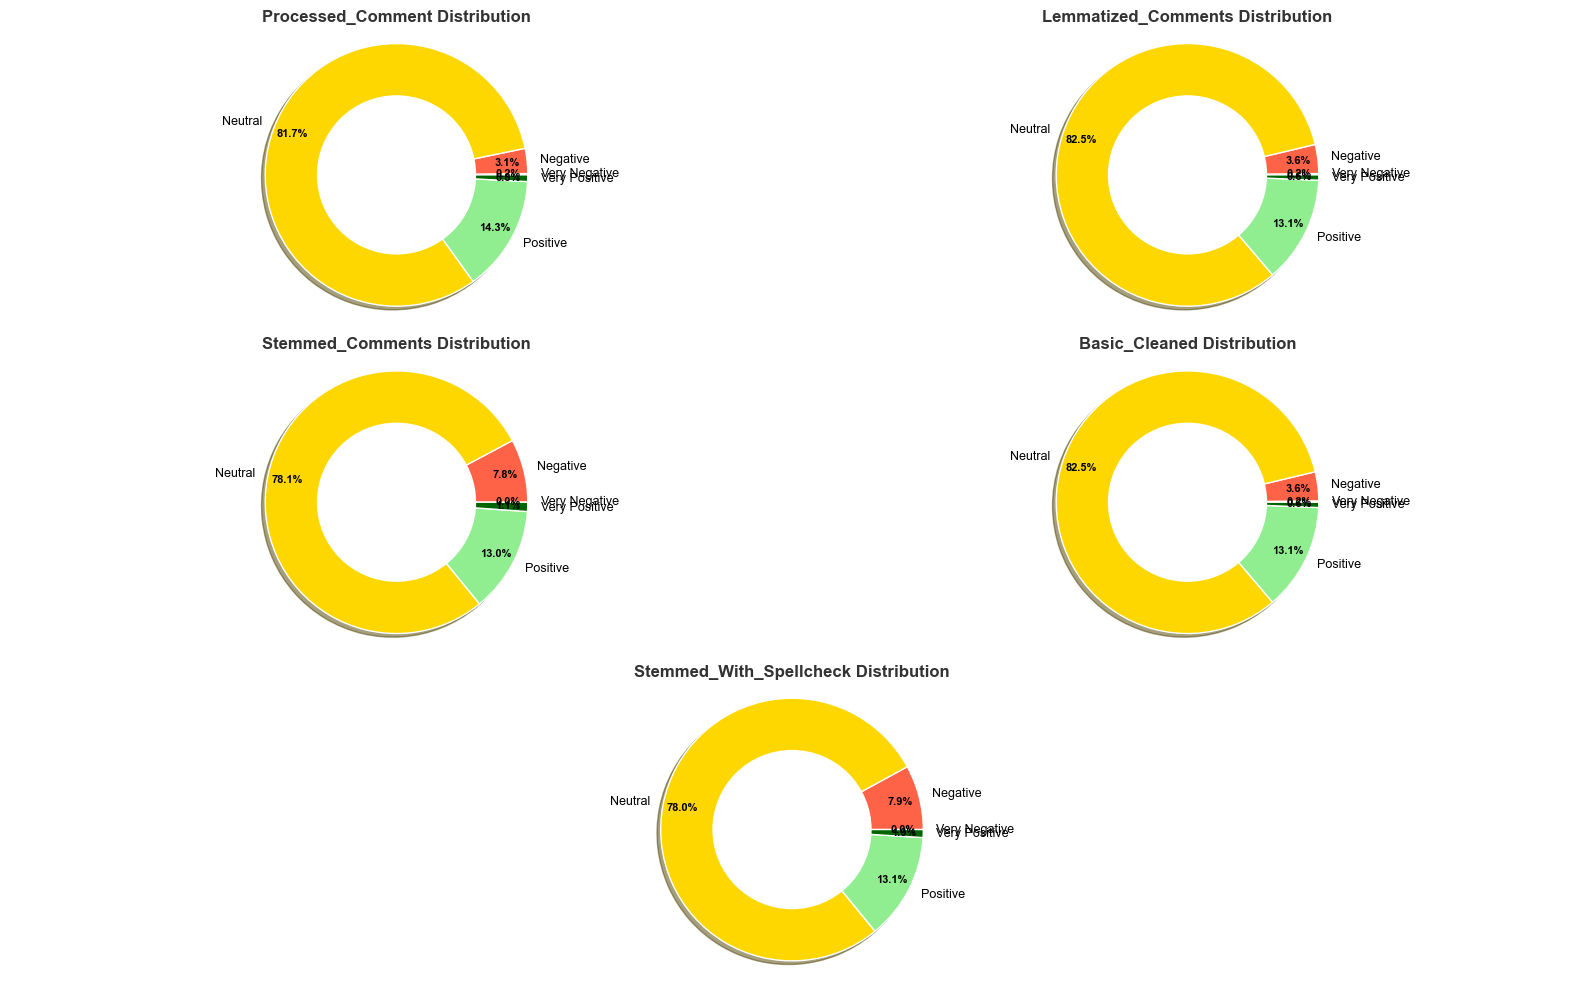

In [40]:
columns = [
    "Processed_Comment_Sentiment_TextBlob",
    "Lemmatized_Comments_Sentiment_TextBlob",
    "Stemmed_Comments_Sentiment_TextBlob",
    "Basic_Cleaned_Sentiment_TextBlob",
    'Stemmed_With_Spellcheck_Sentiment_TextBlob'
]

# Call the function
plot_sentiment_pie_charts(df_textblob_sentiment, columns)


## Time and Sentiment Analysis:

<b>Relationship between Month and Sentiment</b>

In [41]:
df_vader_sentiment.columns

Index(['Comment_ID', 'Document_ID', 'AgencyID', 'City', 'Comment', 'Docket_ID',
       'DocumentType', 'Time of Comment', 'Processed_Comment', 'Tokens',
       'Day_of_Week', 'Month', 'Year', 'Embedding', 'Highest_Similarity_Score',
       'Most_Similar_Comment', 'Similarity_Strat',
       'Is_Duplicate_After_PreProcess', 'Is_Duplicate', 'Time_Difference',
       'Is_Bot', 'tokens', 'Comment_Length', '1-grams', '2-grams', '3-grams',
       'Processed_Comments', 'Lemmatized_Comments', 'Stemmed_Comments',
       'Basic_Cleaned', 'Stemmed_With_Spellcheck',
       'Processed_Comment_Score_Vader', 'Processed_Comment_Sentiment_Vader',
       'Lemmatized_Comments_Score_Vader',
       'Lemmatized_Comments_Sentiment_Vader', 'Stemmed_Comments_Score_Vader',
       'Stemmed_Comments_Sentiment_Vader', 'Basic_Cleaned_Score_Vader',
       'Basic_Cleaned_Sentiment_Vader', 'Stemmed_With_Spellcheck_Score_Vader',
       'Stemmed_With_Spellcheck_Sentiment_Vader',
       'Processed_Comment_Score_TextBlob',

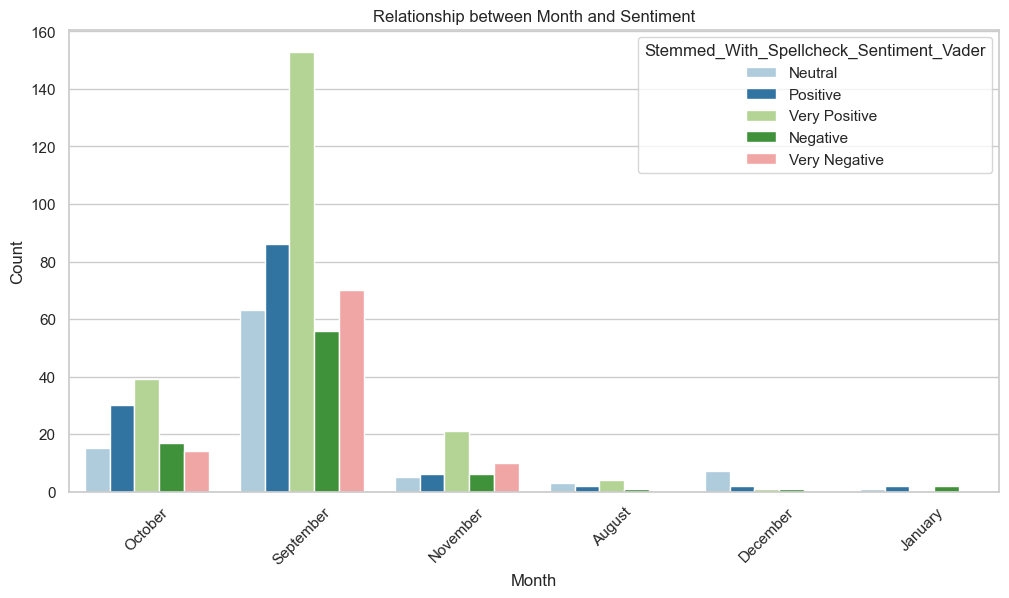

In [42]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Stemmed_With_Spellcheck_Sentiment_Vader', data=df_vader_sentiment, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<b>Relationship between Day of the week and sentiment</b>

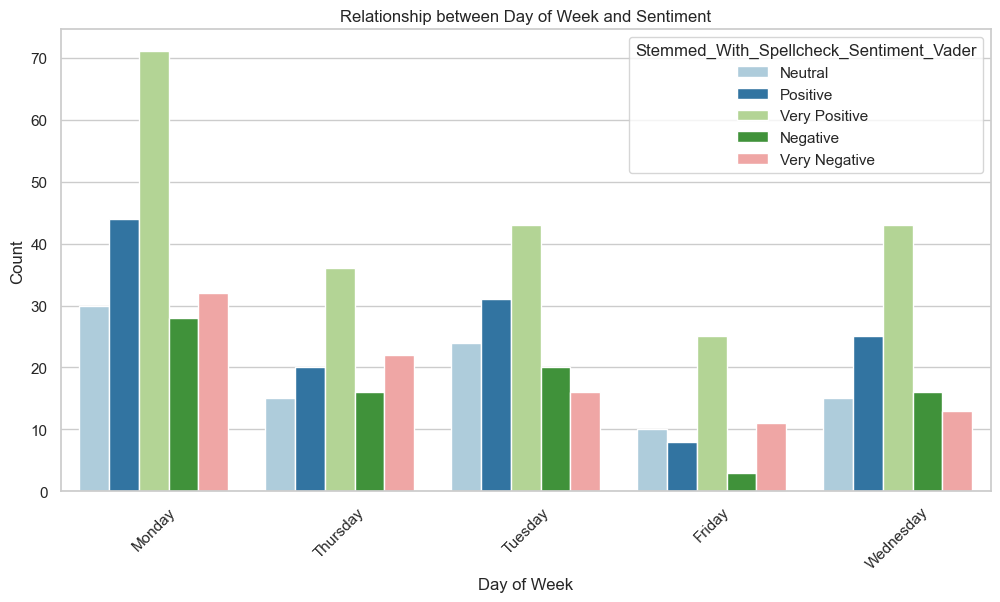

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Stemmed_With_Spellcheck_Sentiment_Vader', data=df_vader_sentiment, palette='Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Word Use and Sentiment:

<b>Sentiment Analysis By Class</b>

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

def generate_sentiment_analysis_by_class(df, sentiment_class, sentiment_column, text_column, top_n=15, table_color=None):
    """
    Generates a word cloud and a table of the most common words for a specific sentiment classification.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing text data and sentiment classifications.
    sentiment_class (str): The specific sentiment to analyze.
    sentiment_column (str): The column name for sentiment classifications.
    text_column (str): The column name for text data.
    top_n (int): The number of most common words to display in the table.
    table_color (str): The color for the background gradient of the table (e.g., 'Greens', 'Reds').

    Returns:
    dict: A dictionary containing the word cloud figure and the table DataFrame.
    """
    # Filter the DataFrame for the specific sentiment
    sentiment_df = df[df[sentiment_column] == sentiment_class]

    # Initialize CountVectorizer for word tokenization
    vectorizer = CountVectorizer(stop_words='english')

    # Fit and transform the data
    transformed_data = vectorizer.fit_transform(sentiment_df[text_column])
    word_counts = transformed_data.sum(axis=0).A1
    word_names = vectorizer.get_feature_names_out()

    # Combine counts with words and sort them
    count_data = list(zip(word_names, word_counts))
    count_data_sorted = sorted(count_data, key=lambda x: x[1], reverse=True)[:top_n]
    most_common_words = pd.DataFrame(count_data_sorted, columns=['Word', 'Count'])

    # Generate and display the word cloud
    wordcloud_text = ' '.join([word for word, _ in count_data_sorted])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment_class} Sentiment", fontsize=16)
    plt.show()

    # Style the table with the chosen color
    styled_table = most_common_words.style.background_gradient(cmap=table_color)
    display(styled_table)

    # Return outputs
    return {
        "wordcloud": wordcloud,
        "table": most_common_words
    }



<b>Creating Color Mapping</b>

In [45]:
# Define the color mapping dictionary
color_mapping = {
    "Very Positive": "Greens",
    "Positive": "Blues",
    "Neutral": "Greys",
    "Negative": "Oranges",
    "Very Negative": "Reds"
}

<b>Very Positive Sentiment</b>

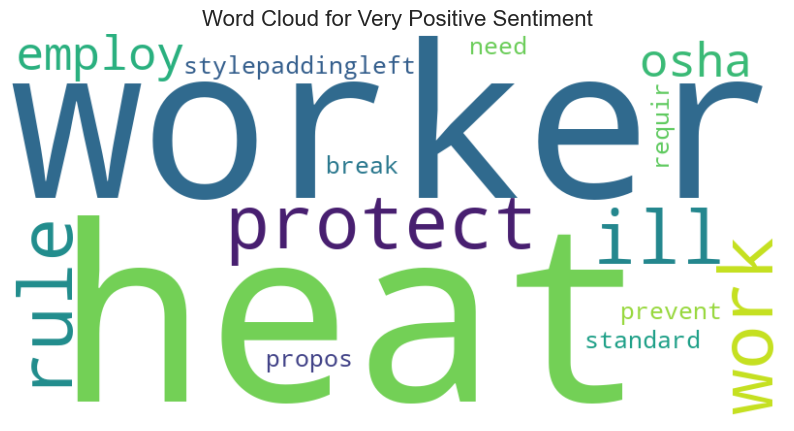

In [46]:
# Generate analyses for each sentiment and store results in variables
very_positive_results = generate_sentiment_analysis_by_class(
    df_comments_sentiment, sentiment_class="Very Positive",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Very Positive"]
)

<b>Positive Sentiment</b>

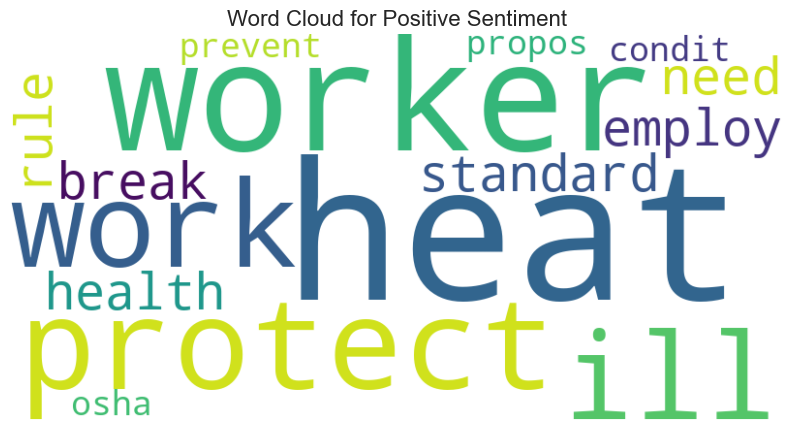

In [47]:
positive_results = generate_sentiment_analysis_by_class(
    df_comments_sentiment, sentiment_class="Positive",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Positive"]
)

<b>Neutral Sentiment</b>

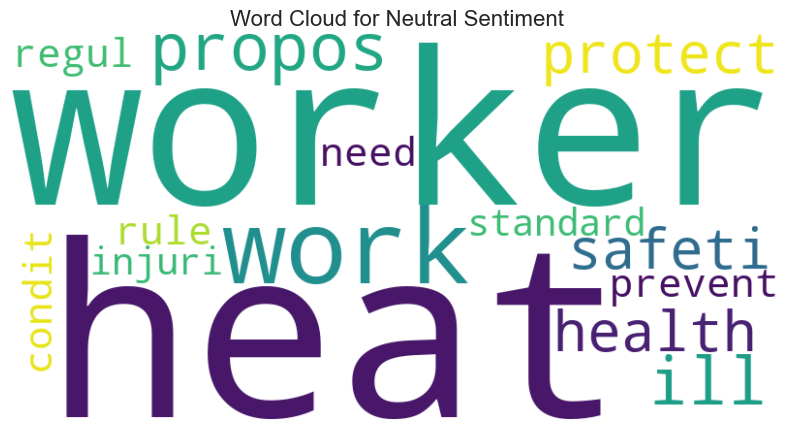

In [48]:
neutral_results = generate_sentiment_analysis_by_class(
    df_comments_sentiment, sentiment_class="Neutral",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Neutral"]
)

<b>Negative Sentiment</b>

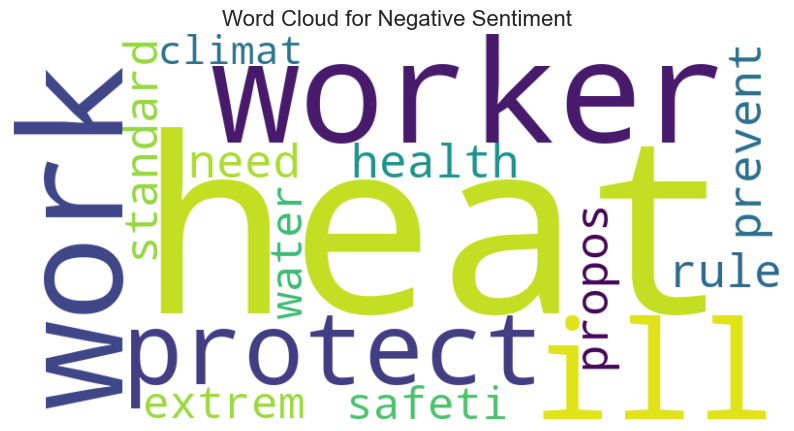

In [49]:
negative_results = generate_sentiment_analysis_by_class(
    df_comments_sentiment, sentiment_class="Negative",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Negative"]
)

<b>Very Negative Sentiment</b>

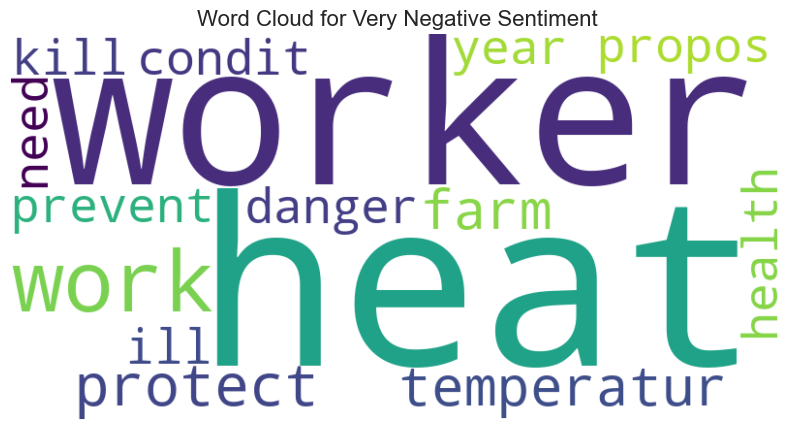

In [50]:
very_negative_results = generate_sentiment_analysis_by_class(
    df_comments_sentiment, sentiment_class="Very Negative",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Very Negative"]
)

<b>Unique N-Grams by Sentiment Classification</b>

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display_html

from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display_html
import pandas as pd

def unique_ngrams_by_sentiment(df, text_column, sentiment_column, n=1, top_n=10):
    """
    Identifies unique n-grams for each sentiment classification and displays styled tables side by side.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing text and sentiment classifications.
    text_column (str): The column name for text data.
    sentiment_column (str): The column name for sentiment classifications.
    n (int): The number of n-grams (e.g., 1 for unigrams, 2 for bigrams).
    top_n (int): The number of top unique n-grams to display per sentiment.

    Returns:
    None: Displays styled tables for each sentiment side by side.
    """
    # Define the desired order of sentiments
    sentiment_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

    # Initialize CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n), analyzer='word')
    sentiment_ngrams = {}

    # Generate n-grams for each sentiment
    for sentiment in sentiment_order:
        sentiment_texts = df[df[sentiment_column] == sentiment][text_column]
        ngram_counts = vectorizer.fit_transform(sentiment_texts)
        ngram_names = vectorizer.get_feature_names_out()
        counts = ngram_counts.sum(axis=0).A1
        sentiment_ngrams[sentiment] = pd.DataFrame({'ngram': ngram_names, 'count': counts}).set_index('ngram')

    # Identify unique n-grams for each sentiment
    unique_ngram_tables = {}
    for sentiment in sentiment_order:
        other_sentiments = [s for s in sentiment_order if s != sentiment]
        combined_ngrams = pd.concat([sentiment_ngrams[s] for s in other_sentiments], axis=0)
        unique_ngrams = sentiment_ngrams[sentiment].loc[~sentiment_ngrams[sentiment].index.isin(combined_ngrams.index)]
        unique_ngram_tables[sentiment] = unique_ngrams.nlargest(top_n, 'count').reset_index()

    # Define sentiment-specific colors
    color_mapping = {
        "Very Positive": "Greens",
        "Positive": "YlGn",
        "Neutral": "YlOrBr",
        "Negative": "OrRd",
        "Very Negative": "Reds"
    }

    # Style and prepare tables for side-by-side display
    styled_tables = []
    for sentiment in sentiment_order:
        table = unique_ngram_tables[sentiment]
        styled_table = table.style.background_gradient(cmap=color_mapping[sentiment]).set_caption(
            f"Unique {n}-grams for {sentiment} Sentiment"
        )
        styled_tables.append(styled_table.to_html())

    # Combine tables into a single HTML block for side-by-side display
    combined_html = "".join(f'<div style="display:inline-block; margin-right:10px;">{table}</div>' for table in styled_tables)
    display_html(combined_html, raw=True)



<b>Unique 3-grams by Sentiment Classification</b>

In [52]:
unique_ngrams_by_sentiment(df_vader_sentiment, text_column='Stemmed_With_Spellcheck', sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader', n=3, top_n=10)


Unique 3-grams for Very Negative Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 heat safeti standard 
 4 
 
 
 1 
 temperatur farm worker 
 4 
 
 
 2 
 danger condit need 
 3 
 
 
 3 
 due heat exposur 
 3 
 
 
 4 
 experi heat ill 
 3 
 
 
 5 
 face increas danger 
 3 
 
 
 6 
 farm worker work 
 3 
 
 
 7 
 fast food kitchen 
 3 
 
 
 8 
 food kitchen swelter 
 3 
 
 
 9 
 kitchen swelter warehous 
 3 
 
 
 
 
 
 Unique 3-grams for Negative Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 employ heat ill 
 2 
 
 
 1 
 human health also 
 2 
 
 
 2 
 occup environment medicin 
 2 
 
 
 3 
 ohio get hot 
 2 
 
 
 4 
 prevent heat stroke 
 2 
 
 
 5 
 prolong heat exposur 
 2 
 
 
 6 
 set propos rule 
 2 
 
 
 7 
 topic climat chang 
 2 
 
 
 8 
 work extrem climat 
 2 
 
 
 9 
 abanico aqua para 
 1 
 
 
 
 
 
 Unique 3-grams for Neutral Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 american short line 
 2 
 
 
 1 
 line region railroad 
 2 
 
 
 2 
 osharsquo heat regulatori 
 2 
 
 
 3 
 propos rule need 
 2 
 
 
 4 
 region railroad associ 
 2 
 
 
 5 
 short line region 
 2 
 
 
 6 
 take sever toll 
 2 
 
 
 7 
 would requir employ 
 2 
 
 
 8 
 absenc basic protect 
 1 
 
 
 9 
 absolut dystopian inhuman 
 1 
 
 
 
 
 
 Unique 3-grams for Positive Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 allow worker take 
 3 
 
 
 1 
 worker take break 
 3 
 
 
 2 
 break air condit 
 2 
 
 
 3 
 framework pleas see 
 2 
 
 
 4 
 hazard implement safeti 
 2 
 
 
 5 
 heat regul brbrsincerelybrmr 
 2 
 
 
 6 
 heatrel death avoid 
 2 
 
 
 7 
 new heat rule 
 2 
 
 
 8 
 pleas protect worker 
 2 
 
 
 9 
 propos rulespan stylepaddingleft 
 2 
 
 
 
 
 
 Unique 3-grams for Very Positive Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 heat hazard plan 
 8 
 
 
 1 
 heat protect degre 
 8 
 
 
 2 
 go long way 
 7 
 
 
 3 
 long way protect 
 6 
 
 
 4 
 outdoor indoor worker 
 6 
 
 
 5 
 protect indoor outdoor 
 6 
 
 
 6 
 protect million worker 
 6 
 
 
 7 
 base scientif evid 
 5 
 
 
 8 
 break shade water 
 5 
 
 
 9 
 deserv keep school 
 5

## Geographical Location and Sentiment

<b>City and Sentiment Analysis:</b>

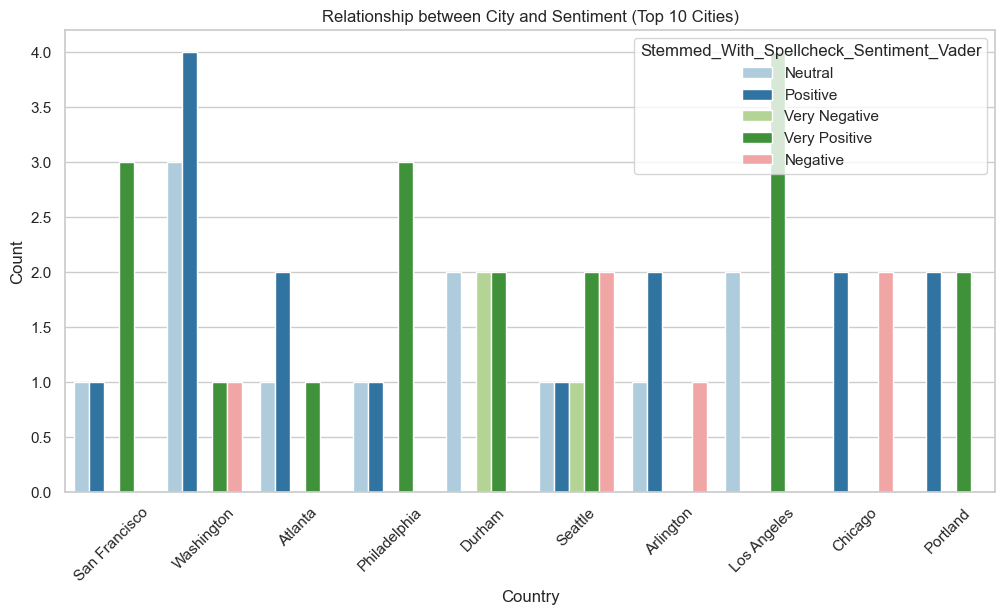

In [53]:
plt.figure(figsize=(12, 6))

top_10_countries = df_vader_sentiment['City'].value_counts().head(10).index

df_top_10_countries = df_vader_sentiment[df_vader_sentiment['City'].isin(top_10_countries)]

sns.countplot(x='City', hue='Stemmed_With_Spellcheck_Sentiment_Vader', data=df_top_10_countries, palette='Paired')
plt.title('Relationship between City and Sentiment (Top 10 Cities)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<b>Geographical Analysis Of Sentiment: Augmenting the Data:</b>

In [54]:
city_coords = pd.read_csv(r'c:\Users\U355394\Desktop\Data_Augmentation_World_Cities.csv')  # Adjust the filename as needed
# Rename the column to 'City'
city_coords.rename(columns={'city': 'City'}, inplace=True)
city_coords = city_coords[city_coords['country'] == 'United States']
# Merge on 'City' column
df_merged = pd.merge(df_vader_sentiment, city_coords, on='City', how='left')
# Remove rows with missing coordinates
df_merged = df_merged.dropna(subset=['lat', 'lng'])
df_merged = df_merged.drop_duplicates(subset=['Comment_ID']).reset_index(drop=True)

<b>Creation of a Map Showing sentiment by location:</b>

In [55]:
import folium
from branca.colormap import LinearColormap
import pandas as pd

# Create the base map
m = folium.Map(location=[df_merged["lat"].mean(), df_merged["lng"].mean()], zoom_start=6)

# Define the color scale
colormap = LinearColormap(
    colors=["red", "white", "blue"],
    vmin=-1,  # Minimum value for Vader_Score
    vmax=1,   # Maximum value for Vader_Score
    caption="Sentiment"
)

# Add the color scale to the map
colormap.add_to(m)

# Add points to the map
for _, row in df_merged.iterrows():
    # Determine color based on Vader_Score
    color = colormap(row["Stemmed_With_Spellcheck_Score_Vader"])
    
    # Add a circle marker with tooltip for Vader_Score
    folium.CircleMarker(
        location=(row["lat"], row["lng"]),
        radius=7,  # Marker size
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        tooltip=f"Vader Score: {row['Stemmed_With_Spellcheck_Score_Vader']}"  # Tooltip to display on hover
    ).add_to(m)

# Save or display the map
m


## Bot Comments

In [56]:
df_bot_copy = df_bot.copy()

<b>We conduct the same cleaning steps with the bot comments</b>

In [57]:
# Apply preprocessing to the DataFrame
df_bot_copy['Processed_Comments'] = df_bot_copy['Comment'].apply(clean_text)
df_bot_copy['Lemmatized_Comments'] = df_bot_copy['Processed_Comments'].apply(
    lambda x: " ".join(word_tokenize(x))
)
df_bot_copy['Stemmed_Comments'] = df_bot_copy['Processed_Comments'].apply(
    lambda x: " ".join(stemmer.stem(word) for word in tokenize_and_filter(x))
)
df_bot_copy['Basic_Cleaned'] = df_bot_copy['Comment'].apply(clean_text)

# Create a new column: Spell-Checked and Stemmed
df_bot_copy['Stemmed_With_Spellcheck'] = df_bot_copy['Processed_Comments'].apply(spell_check).apply(
    lambda x: " ".join(stemmer.stem(word) for word in tokenize_and_filter(x))
)

# Display the resulting DataFrame
df_bot_copy[['Comment', 'Processed_Comments', 'Lemmatized_Comments', 'Stemmed_Comments', 'Stemmed_With_Spellcheck']].head()

Comment  \
0  Every worker deserves protection from extreme ...   
1  I fully support the Occupational Safety and He...   
2  Every worker deserves protection from extreme ...   
3  I am writing to support the proposed OSHA rule...   
4  I fully support the Occupational Safety and He...   

                                  Processed_Comments  \
0  Every worker deserves protection from extreme ...   
1  fully support the Occupational Safety and Heal...   
2  Every worker deserves protection from extreme ...   
3  am writing to support the proposed OSHA rule t...   
4  fully support the Occupational Safety and Heal...   

                                 Lemmatized_Comments  \
0  Every worker deserves protection from extreme ...   
1  fully support the Occupational Safety and Heal...   
2  Every worker deserves protection from extreme ...   
3  am writing to support the proposed OSHA rule t...   
4  fully support the Occupational Safety and Heal...   

                                    Stemmed_Comments  \
0  everi worker deserv protect extrem heat rsquo ...   
1  fulli support occup safeti health administrati...   
2  everi worker deserv protect extrem heat rsquo ...   
3  write support propos osha rule protect nonresi...   
4  fulli support occup safeti health administrati...   

                             Stemmed_With_Spellcheck  
0  worker deserv protect extrem heat quo write ex...  
1  fulli support occup safeti health administrati...  
2  worker deserv protect extrem heat quo write ex...  
3  write support propos osha rule protect nonresi...  
4  fulli support occup safeti health administrati...

In [58]:
# Columns to analyze
text_columns = [
    "Processed_Comment",
    "Lemmatized_Comments",
    "Stemmed_Comments",
    "Basic_Cleaned",
    "Stemmed_With_Spellcheck"
]

# Perform sentiment analysis with VADER
df_bot_vader_sentiment = analyze_sentiment(df_bot_copy, text_columns, analyzer="vader")
print("VADER Sentiment Analysis Results:")
print(df_bot_vader_sentiment.head())

# Perform sentiment analysis with TextBlob
df_bot_textblob_sentiment = analyze_sentiment(df_bot_copy, text_columns, analyzer="textblob")
print("\nTextBlob Sentiment Analysis Results:")
print(df_bot_vader_sentiment.head())

VADER Sentiment Analysis Results:
             Comment_ID          Document_ID AgencyID                    City  \
0  OSHA-2021-0009-12956  OSHA-2021-0009-4761     OSHA            Philadelphia   
1  OSHA-2021-0009-15413  OSHA-2021-0009-4761     OSHA            Mount Vernon   
2  OSHA-2021-0009-13439  OSHA-2021-0009-4761     OSHA  Rancho Santa Margarita   
3  OSHA-2021-0009-10699  OSHA-2021-0009-4761     OSHA                New York   
4  OSHA-2021-0009-15026  OSHA-2021-0009-4761     OSHA           New Braunfels   

                                             Comment       Docket_ID  \
0  Every worker deserves protection from extreme ...  OSHA-2021-0009   
1  I fully support the Occupational Safety and He...  OSHA-2021-0009   
2  Every worker deserves protection from extreme ...  OSHA-2021-0009   
3  I am writing to support the proposed OSHA rule...  OSHA-2021-0009   
4  I fully support the Occupational Safety and He...  OSHA-2021-0009   

        DocumentType     Time of Comment  \
0 

<b>Comparing Sentiment Distribution for Bot Comments</b>

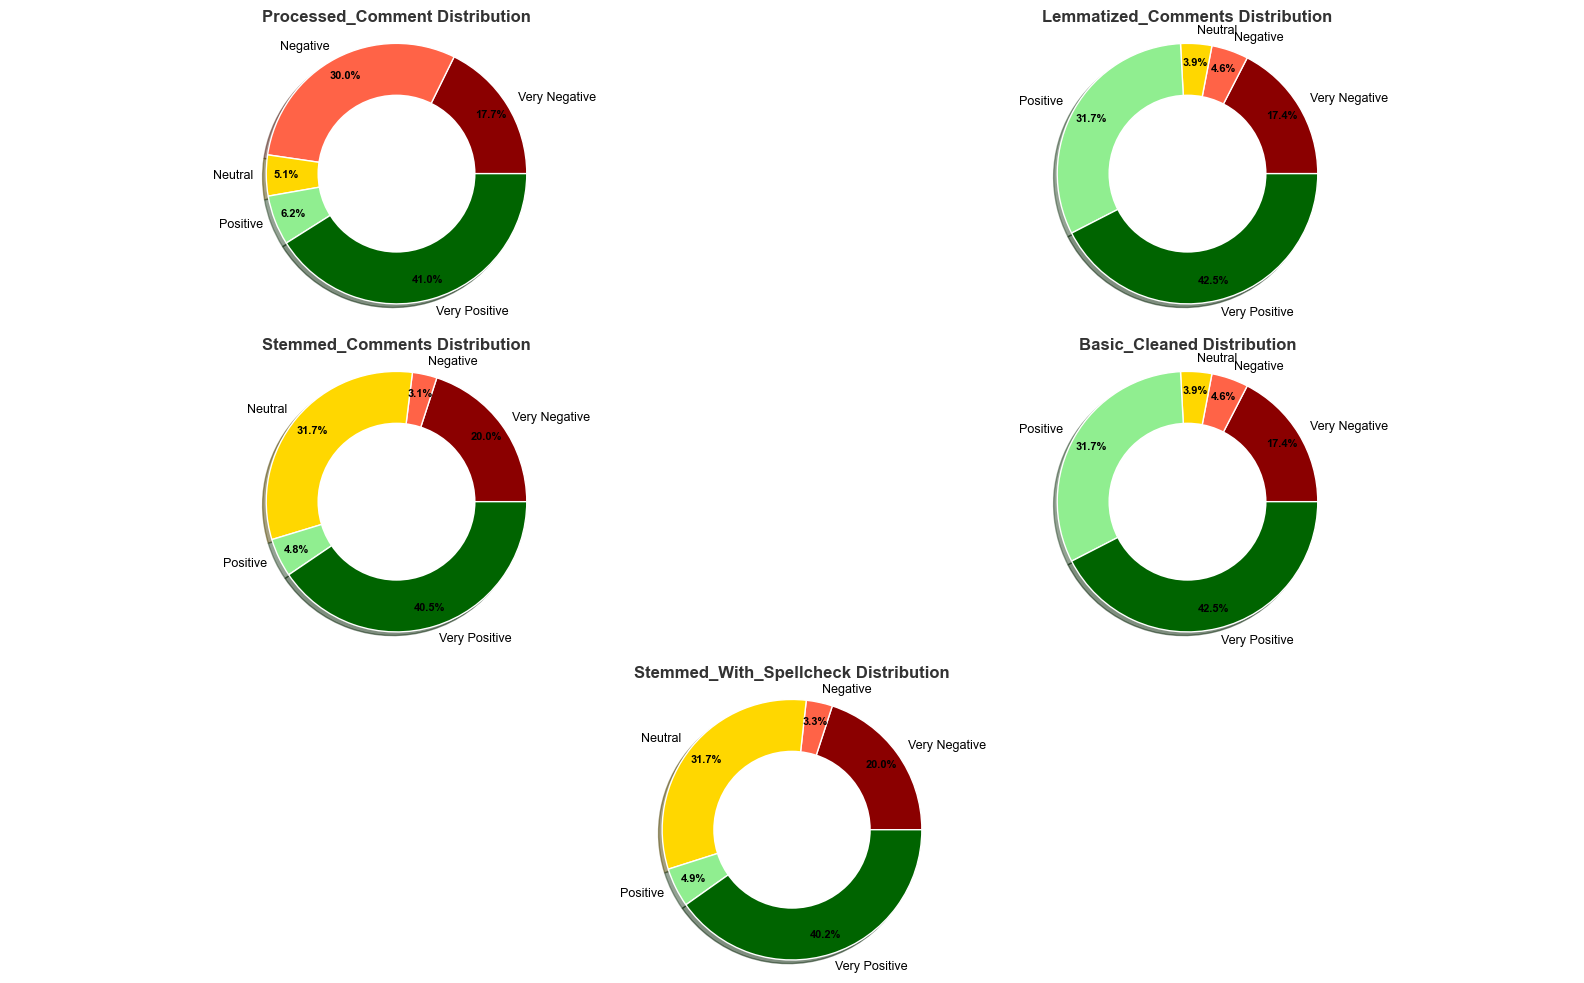

In [59]:
columns = [
    "Processed_Comment_Sentiment_Vader",
    "Lemmatized_Comments_Sentiment_Vader",
    "Stemmed_Comments_Sentiment_Vader",
    "Basic_Cleaned_Sentiment_Vader",
    'Stemmed_With_Spellcheck_Sentiment_Vader'
]
# Call the function
plot_sentiment_pie_charts(df_bot_vader_sentiment, columns)

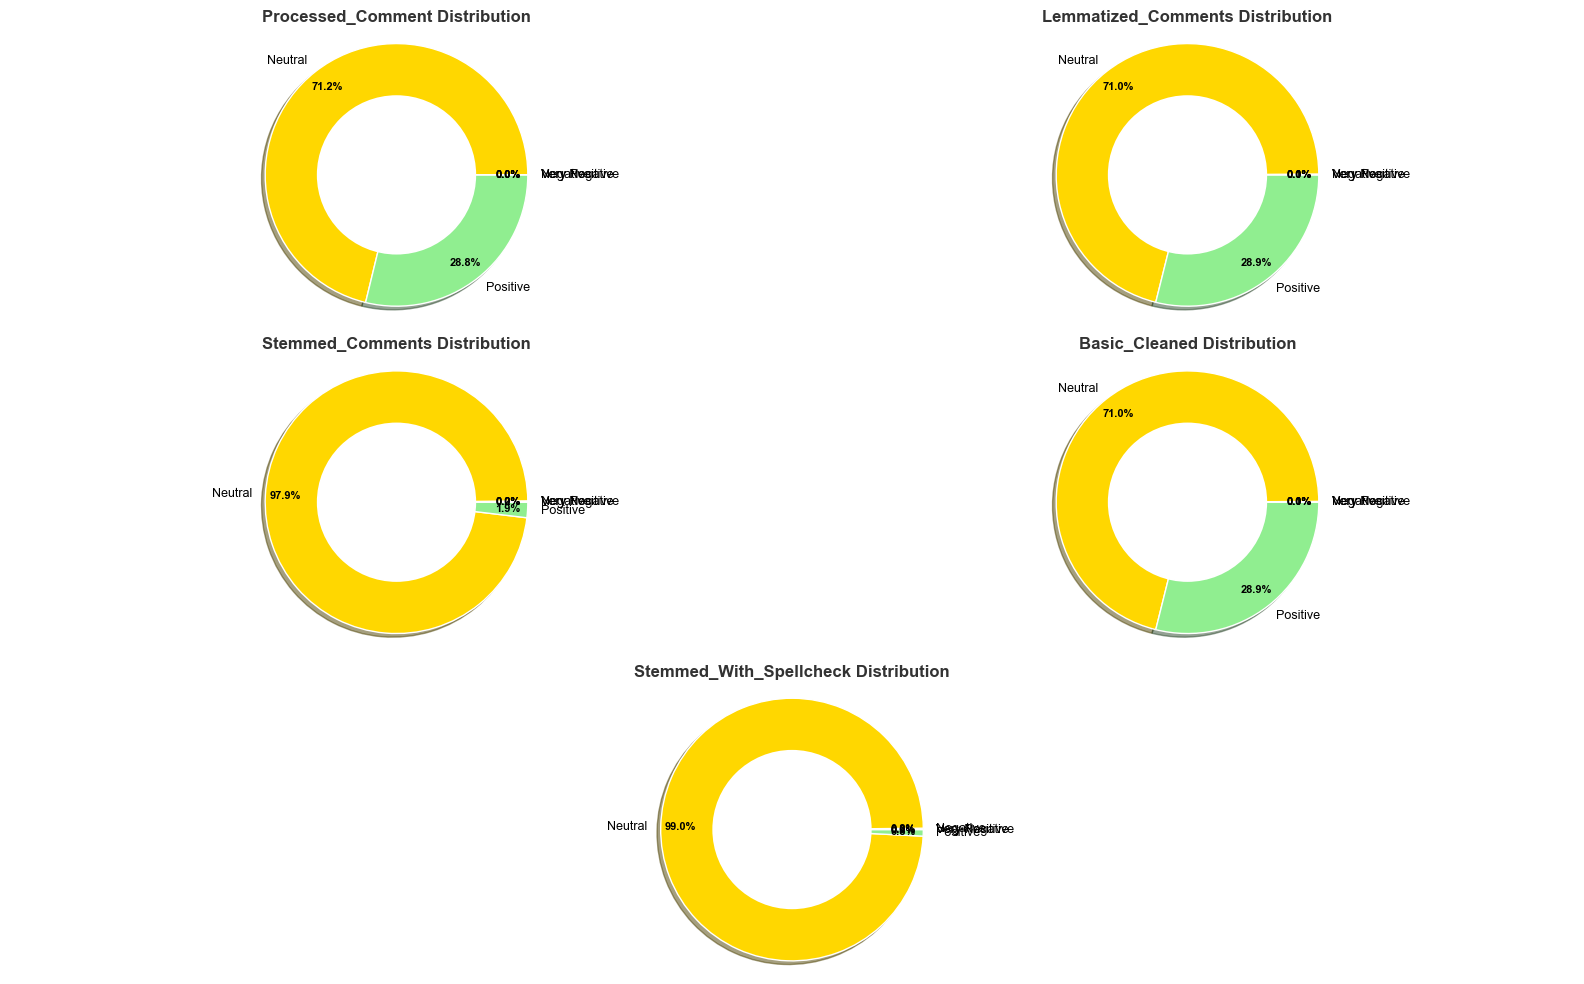

In [60]:
columns = [
    "Processed_Comment_Sentiment_TextBlob",
    "Lemmatized_Comments_Sentiment_TextBlob",
    "Stemmed_Comments_Sentiment_TextBlob",
    "Basic_Cleaned_Sentiment_TextBlob",
    'Stemmed_With_Spellcheck_Sentiment_TextBlob'
]
plot_sentiment_pie_charts(df_bot_textblob_sentiment, columns)

### Word Use And Sentiment

<b>Very Positive Sentiment</b>

In [61]:
unique_ngrams_by_sentiment(df_vader_sentiment, text_column='Stemmed_With_Spellcheck', sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader', n=3, top_n=10)


Unique 3-grams for Very Negative Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 heat safeti standard 
 4 
 
 
 1 
 temperatur farm worker 
 4 
 
 
 2 
 danger condit need 
 3 
 
 
 3 
 due heat exposur 
 3 
 
 
 4 
 experi heat ill 
 3 
 
 
 5 
 face increas danger 
 3 
 
 
 6 
 farm worker work 
 3 
 
 
 7 
 fast food kitchen 
 3 
 
 
 8 
 food kitchen swelter 
 3 
 
 
 9 
 kitchen swelter warehous 
 3 
 
 
 
 
 
 Unique 3-grams for Negative Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 employ heat ill 
 2 
 
 
 1 
 human health also 
 2 
 
 
 2 
 occup environment medicin 
 2 
 
 
 3 
 ohio get hot 
 2 
 
 
 4 
 prevent heat stroke 
 2 
 
 
 5 
 prolong heat exposur 
 2 
 
 
 6 
 set propos rule 
 2 
 
 
 7 
 topic climat chang 
 2 
 
 
 8 
 work extrem climat 
 2 
 
 
 9 
 abanico aqua para 
 1 
 
 
 
 
 
 Unique 3-grams for Neutral Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 american short line 
 2 
 
 
 1 
 line region railroad 
 2 
 
 
 2 
 osharsquo heat regulatori 
 2 
 
 
 3 
 propos rule need 
 2 
 
 
 4 
 region railroad associ 
 2 
 
 
 5 
 short line region 
 2 
 
 
 6 
 take sever toll 
 2 
 
 
 7 
 would requir employ 
 2 
 
 
 8 
 absenc basic protect 
 1 
 
 
 9 
 absolut dystopian inhuman 
 1 
 
 
 
 
 
 Unique 3-grams for Positive Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 allow worker take 
 3 
 
 
 1 
 worker take break 
 3 
 
 
 2 
 break air condit 
 2 
 
 
 3 
 framework pleas see 
 2 
 
 
 4 
 hazard implement safeti 
 2 
 
 
 5 
 heat regul brbrsincerelybrmr 
 2 
 
 
 6 
 heatrel death avoid 
 2 
 
 
 7 
 new heat rule 
 2 
 
 
 8 
 pleas protect worker 
 2 
 
 
 9 
 propos rulespan stylepaddingleft 
 2 
 
 
 
 
 
 Unique 3-grams for Very Positive Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 heat hazard plan 
 8 
 
 
 1 
 heat protect degre 
 8 
 
 
 2 
 go long way 
 7 
 
 
 3 
 long way protect 
 6 
 
 
 4 
 outdoor indoor worker 
 6 
 
 
 5 
 protect indoor outdoor 
 6 
 
 
 6 
 protect million worker 
 6 
 
 
 7 
 base scientif evid 
 5 
 
 
 8 
 break shade water 
 5 
 
 
 9 
 deserv keep school 
 5

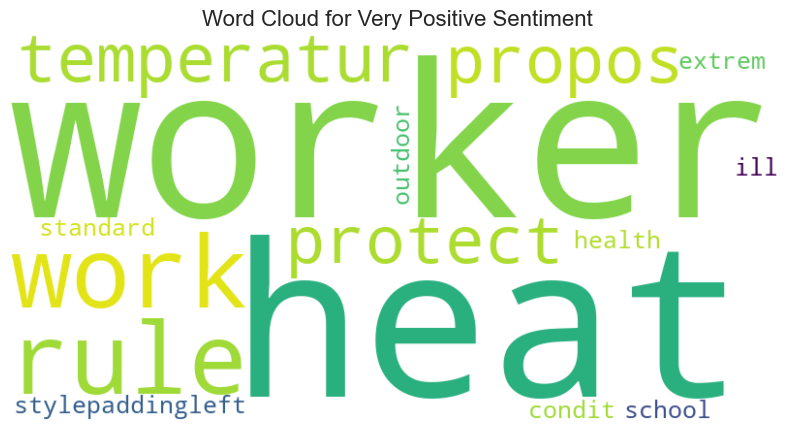

In [62]:
# Generate analyses for each sentiment and store results in variables
very_positive_results = generate_sentiment_analysis_by_class(
    df_bot_vader_sentiment, sentiment_class="Very Positive",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Very Positive"]
)

<b>Positive Sentiment</b>

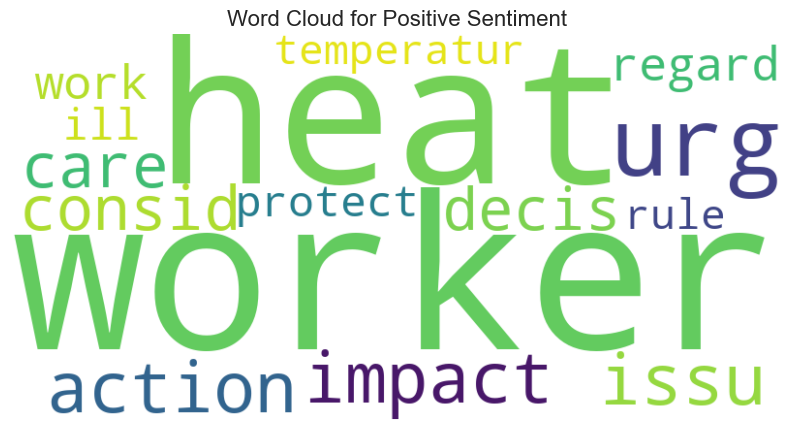

In [63]:
positive_results = generate_sentiment_analysis_by_class(
    df_bot_vader_sentiment, sentiment_class="Positive",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Positive"]
)

<b>Neutral Sentiment</b>

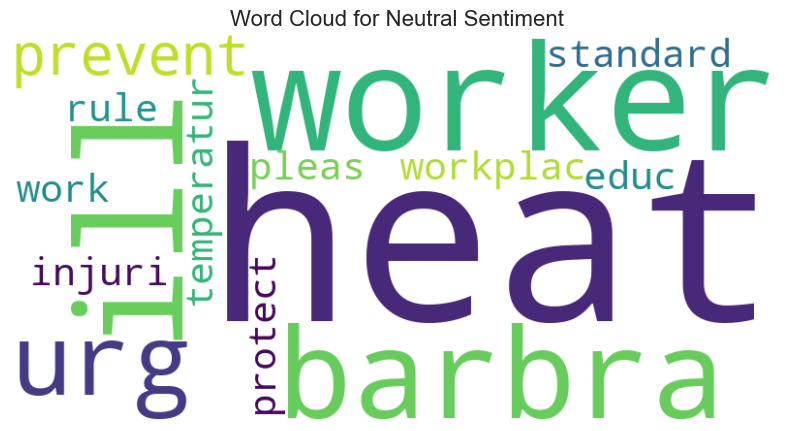

In [64]:
neutral_results = generate_sentiment_analysis_by_class(
    df_bot_vader_sentiment, sentiment_class="Neutral",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Neutral"]
)

<b>Negative Sentiment</b>

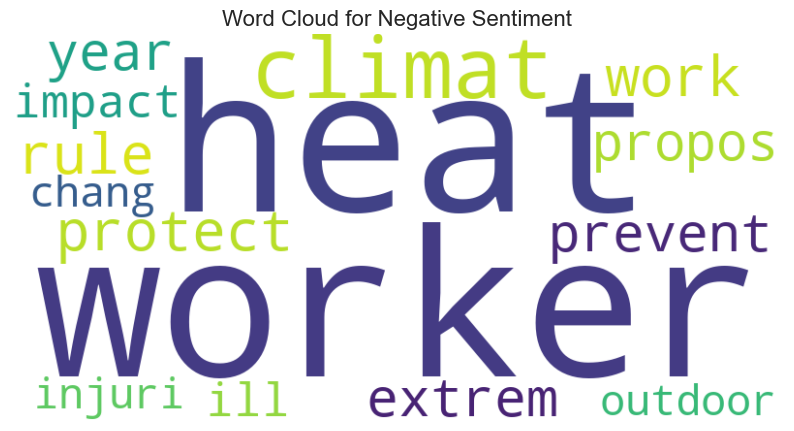

In [65]:
negative_results = generate_sentiment_analysis_by_class(
    df_bot_vader_sentiment, sentiment_class="Negative",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Negative"]
)

<b>Very Negative Sentiment</b>

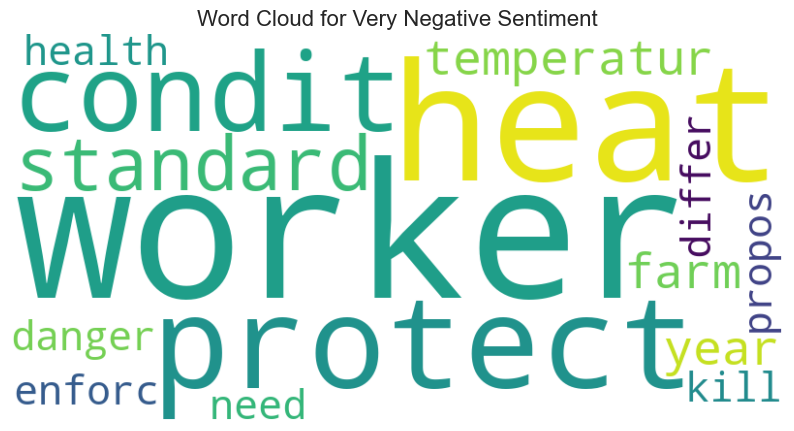

In [66]:
very_negative_results = generate_sentiment_analysis_by_class(
    df_bot_vader_sentiment, sentiment_class="Very Negative",sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader',text_column='Stemmed_With_Spellcheck', table_color=color_mapping["Very Negative"]
)

<b>Unique 3-Grams by Sentiment Classification</b>

In [67]:
unique_ngrams_by_sentiment(df_bot_vader_sentiment, text_column='Stemmed_With_Spellcheck', sentiment_column='Stemmed_With_Spellcheck_Sentiment_Vader', n=5, top_n=10)


Unique 5-grams for Very Negative Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 account employe behavior individu health 
 466 
 
 
 1 
 addit lifestyl choic behavior unrel 
 466 
 
 
 2 
 advers effect heat exposur without 
 466 
 
 
 3 
 also increas potenti individu suffer 
 466 
 
 
 4 
 base varieti factor includ medic 
 466 
 
 
 5 
 behavior individu health condit could 
 466 
 
 
 6 
 behavior unrel medic condit also 
 466 
 
 
 7 
 choic behavior unrel medic condit 
 466 
 
 
 8 
 climat account employe behavior individu 
 466 
 
 
 9 
 condit also increas potenti individu 
 466 
 
 
 
 
 
 Unique 5-grams for Negative Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 barbra worker must train recogn 
 4 
 
 
 1 
 commun healthcar profession see emerg 
 4 
 
 
 2 
 drink water barbra worker must 
 4 
 
 
 3 
 healthcar profession see emerg room 
 4 
 
 
 4 
 includ commun healthcar profession see 
 4 
 
 
 5 
 made final propos rulebrbrsincerelybrm susan 
 4 
 
 
 6 
 made final propos rulebrbrsincerelybrmr michael 
 4 
 
 
 7 
 made final propos rulebrbrsincerelybrmr robert 
 4 
 
 
 8 
 must train recogn respond sign 
 4 
 
 
 9 
 profession see emerg room visit 
 4 
 
 
 
 
 
 Unique 5-grams for Neutral Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 indoor work set standard pocket 
 19 
 
 
 1 
 write support heat injuri ill 
 19 
 
 
 2 
 work set standard pocket comment 
 17 
 
 
 3 
 administr move forward propos rulebrbrsincerelybr 
 9 
 
 
 4 
 stronger requir employ justifi contrbrbrsincerelybrdr 
 8 
 
 
 5 
 administr move forward propos rulebrbrsincerelybrmichael 
 6 
 
 
 6 
 citizen urg occup safeti health 
 5 
 
 
 7 
 concern citizen urg occup safeti 
 5 
 
 
 8 
 administr move forward propos rulebrbrsincerelybrcharl 
 4 
 
 
 9 
 administr move forward propos rulebrbrsincerelybrjudith 
 4 
 
 
 
 
 
 Unique 5-grams for Positive Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 condit brbullspan stylepaddingleft farm worbrbrsincerelybrmr 
 24 
 
 
 1 
 condit brbullspan stylepaddingleft farm worbrbrsincerelybrm 
 11 
 
 
 2 
 decis action regard issu havebrbrsincerelybrmaria 
 8 
 
 
 3 
 decis action regard issu havebrbrsincerelybrlaura 
 6 
 
 
 4 
 decis action regard issu havebrbrsincerelybrbrenda 
 5 
 
 
 5 
 decis action regard issu havebrbrsincerelybrstephani 
 5 
 
 
 6 
 decis action regard issu havebrbrsincerelybrchristina 
 4 
 
 
 7 
 decis action regard issu havebrbrsincerelybrdaniel 
 4 
 
 
 8 
 decis action regard issu havebrbrsincerelybrmelissa 
 4 
 
 
 9 
 decis action regard issu havebrbrsincerelybrtina 
 4 
 
 
 
 
 
 Unique 5-grams for Very Positive Sentiment 
 
 
   
 ngram 
 count 
 
 
 
 
 0 
 keep school safe thank considerationbrbrsincerelybrdr 
 69 
 
 
 1 
 keep school safe thank considerationbrbrsincerelybrmiss 
 36 
 
 
 2 
 way protect worker save livesbrbrsincerelybrmari 
 25 
 
 
 3 
 also set standard respond grow 
 16 
 
 
 4 
 commend osha take import step 
 16 
 
 
 5 
 depend rule save live also 
 16 
 
 
 6 
 extrem heat workplac commend osha 
 16 
 
 
 7 
 final rule implement without delaybrbrthank 
 16 
 
 
 8 
 grow threat extrem heat workplac 
 16 
 
 
 9 
 hazardsbrbrin close strongli urg osha 
 16